# Clustering of Mouse and Human classified V1 neurons

In [1]:
import numpy as np
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt
import scanpy as sc
from sklearn.metrics import silhouette_score


# Mouse Clustering

In [2]:
# Import mouse annotations
mouse_annotation = sc.read_h5ad("data/annotated_data/mouse_neurons_rpca_xgb+skinnider+knaf14.h5ad")
mouse_annotation

AnnData object with n_obs × n_vars = 28221 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'species', 'doublet_finder', 'percent_mito', 'keep', 'nCount_SCT', 'nFeature_SCT', 'GFP', 'RNA_snn_res.2', 'seurat_clusters', 'training_labels', 'citeseq', 'annotation', 'labels_xgb', 'v1'
    var: 'vf_vst_counts.BOUV5_mean', 'vf_vst_counts.BOUV5_variance', 'vf_vst_counts.BOUV5_variance.expected', 'vf_vst_counts.BOUV5_variance.standardized', 'vf_vst_counts.BOUV5_variable', 'vf_vst_counts.BOUV5_rank', 'vf_vst_counts.KATHE_mean', 'vf_vst_counts.KATHE_variance', 'vf_vst_counts.KATHE_variance.expected', 'vf_vst_counts.KATHE_variance.standardized', 'vf_vst_counts.KATHE_variable', 'vf_vst_counts.KATHE_rank', 'vf_vst_counts.MATSON_mean', 'vf_vst_counts.MATSON_variance', 'vf_vst_counts.MATSON_variance.expected', 'vf_vst_counts.MATSON_variance.standardized', 'vf_vst_counts.MATSON_variable', 'vf_vst_counts.MATSON_rank', 'vf_vst_counts.KNAF3_mean', 'vf_vst_counts.KNAF3_variance', 'vf_vst_counts.

In [3]:
# Extract V1 neurons
V1 = mouse_annotation[mouse_annotation.obs['v1'] == 'V1']
V1

View of AnnData object with n_obs × n_vars = 4183 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'species', 'doublet_finder', 'percent_mito', 'keep', 'nCount_SCT', 'nFeature_SCT', 'GFP', 'RNA_snn_res.2', 'seurat_clusters', 'training_labels', 'citeseq', 'annotation', 'labels_xgb', 'v1'
    var: 'vf_vst_counts.BOUV5_mean', 'vf_vst_counts.BOUV5_variance', 'vf_vst_counts.BOUV5_variance.expected', 'vf_vst_counts.BOUV5_variance.standardized', 'vf_vst_counts.BOUV5_variable', 'vf_vst_counts.BOUV5_rank', 'vf_vst_counts.KATHE_mean', 'vf_vst_counts.KATHE_variance', 'vf_vst_counts.KATHE_variance.expected', 'vf_vst_counts.KATHE_variance.standardized', 'vf_vst_counts.KATHE_variable', 'vf_vst_counts.KATHE_rank', 'vf_vst_counts.MATSON_mean', 'vf_vst_counts.MATSON_variance', 'vf_vst_counts.MATSON_variance.expected', 'vf_vst_counts.MATSON_variance.standardized', 'vf_vst_counts.MATSON_variable', 'vf_vst_counts.MATSON_rank', 'vf_vst_counts.KNAF3_mean', 'vf_vst_counts.KNAF3_variance', 'vf_vst_

In [4]:
# Compute UMAP representation using RPCA representation
sc.neighbors.neighbors(V1, use_rep='X_rpca')
sc.tl.umap(V1)

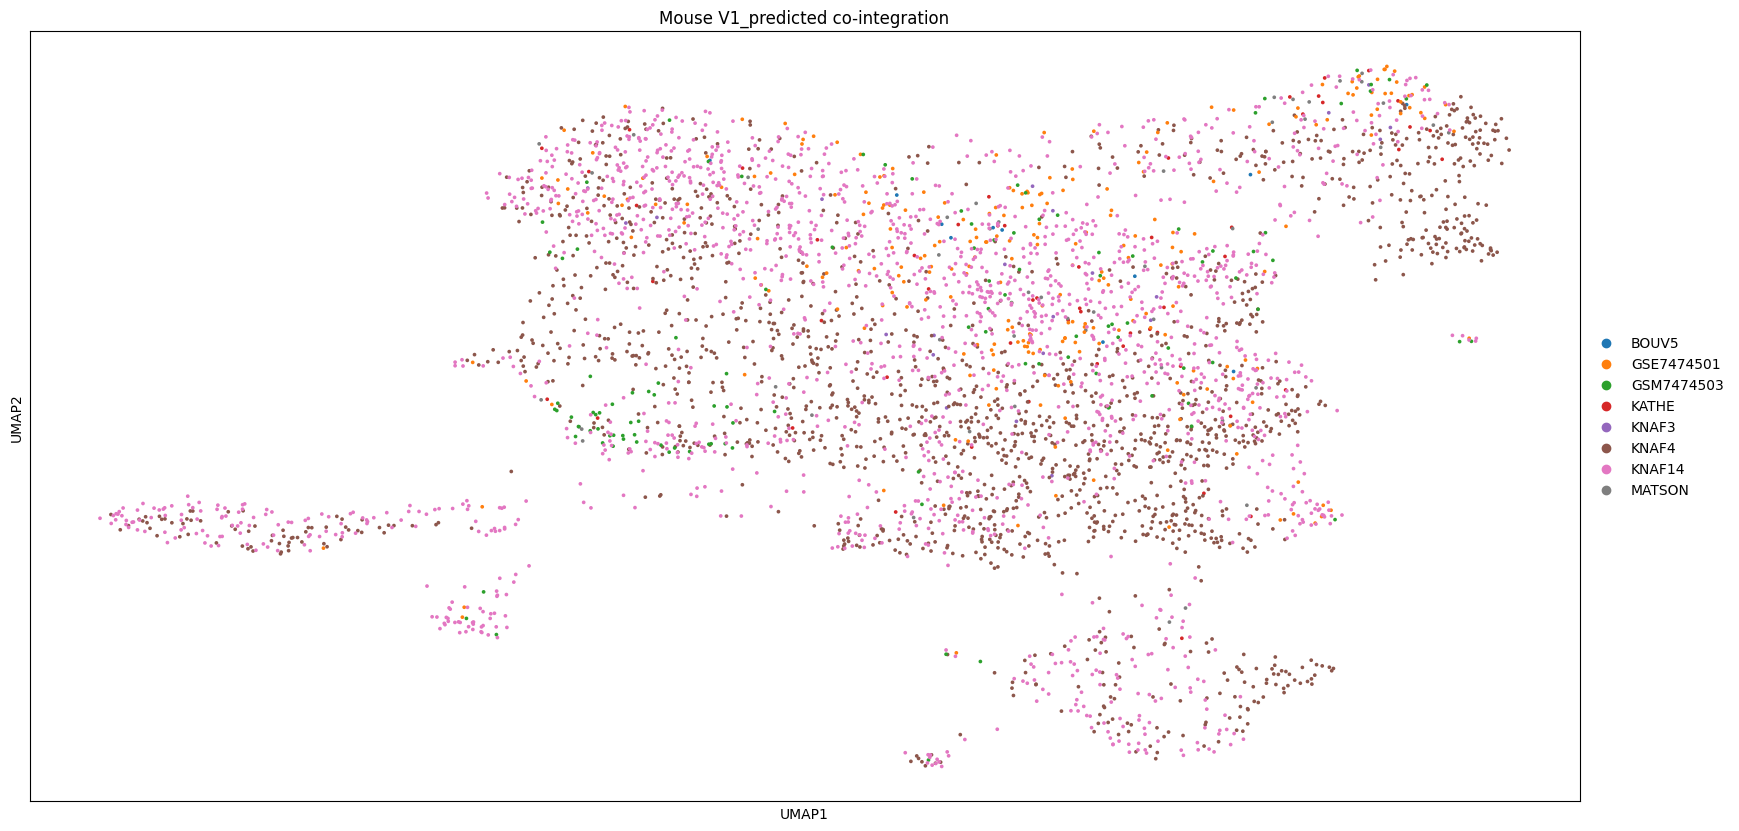

In [5]:
fig, ax = plt.subplots(1,1, figsize = (20,10))
sc.pl.umap(V1, color='orig.ident', ax = ax, title = 'Mouse V1_predicted co-integration')

## Clustering using raw data

In [6]:
from sklearn.cluster import AgglomerativeClustering
X = V1.X

clustering = AgglomerativeClustering(n_clusters=5).fit(X)

V1.obs['agglo_clusters'] = clustering.labels_
V1.obs['agglo_clusters'] = V1.obs['agglo_clusters'].astype('category')

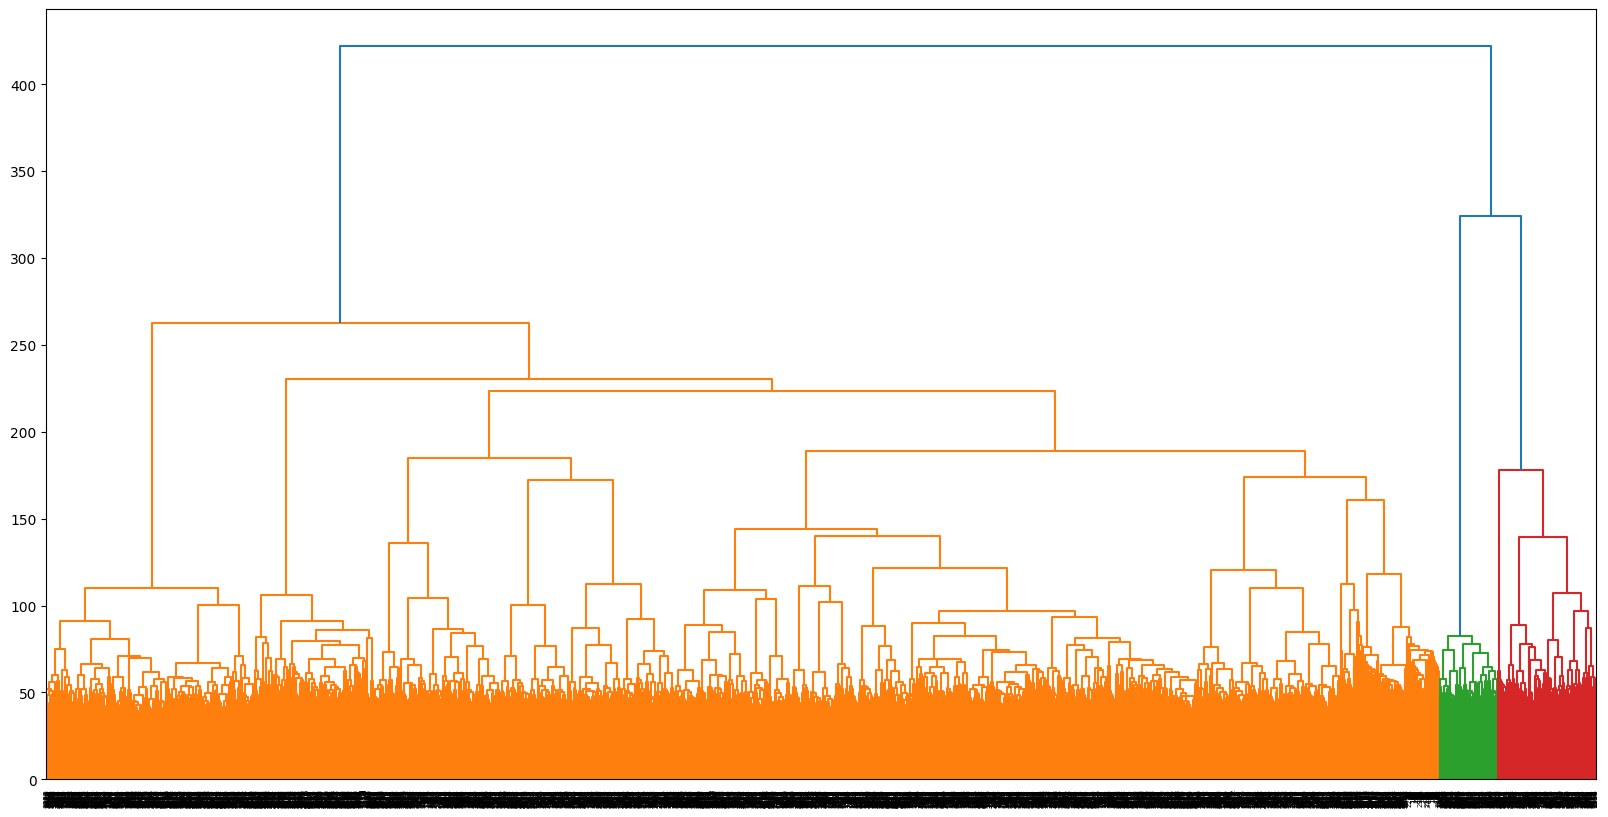

In [7]:
Z = hierarchy.linkage(X, 'ward')
fig, ax = plt.subplots(1,1, figsize = (20,10))
d = hierarchy.dendrogram(Z)

In [8]:
order = {}
for i in range(len(d['leaves'])):
    order[d['leaves'][i]] = d['leaves_color_list'][i]
res = {key: val for key, val in sorted(order.items(), key = lambda ele: ele[0])}
order = res

In [9]:
V1.uns['divise_clusters_colors'] = ['orange', 'green', 'red', 'violet']
V1.obs['divise_clusters'] = order.values()

In [10]:
from sklearn.cluster import KMeans
cluster_labels = KMeans(n_clusters=5, random_state=42).fit_predict(X)
V1.obs['kmeans_clusters'] = cluster_labels
V1.obs['kmeans_clusters'] = V1.obs['kmeans_clusters'].astype('category')

In [11]:
sc.neighbors.neighbors(V1)
sc.tl.leiden(V1, resolution=0.1)

C:\Users\Emile\AppData\Local\Temp\ipykernel_6552\3105514463.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(V1, resolution=0.1)


In [12]:

print('agglo clust: ', silhouette_score(V1.X, V1.obs['agglo_clusters']))
print('divise clust: ', silhouette_score(V1.X, V1.obs['divise_clusters']))
print('leiden: ', silhouette_score(V1.X, V1.obs['leiden']))
print('kmeans clust: ', silhouette_score(V1.X, V1.obs['kmeans_clusters']))

agglo clust:  -0.006017442508837482
divise clust:  0.07498947855254354
leiden:  0.028240902247553334
kmeans clust:  0.01072219708250705


In [13]:
print('agglo clust: ', silhouette_score(V1.obsm['X_rpca'], V1.obs['agglo_clusters']))
print('divise clust: ', silhouette_score(V1.obsm['X_rpca'], V1.obs['divise_clusters']))
print('leiden: ', silhouette_score(V1.obsm['X_rpca'], V1.obs['leiden']))
print('kmeans clust: ', silhouette_score(V1.obsm['X_rpca'], V1.obs['kmeans_clusters']))

agglo clust:  0.08130384592730373
divise clust:  0.26142845007822046
leiden:  0.06936720692254757
kmeans clust:  -0.051035995396063606


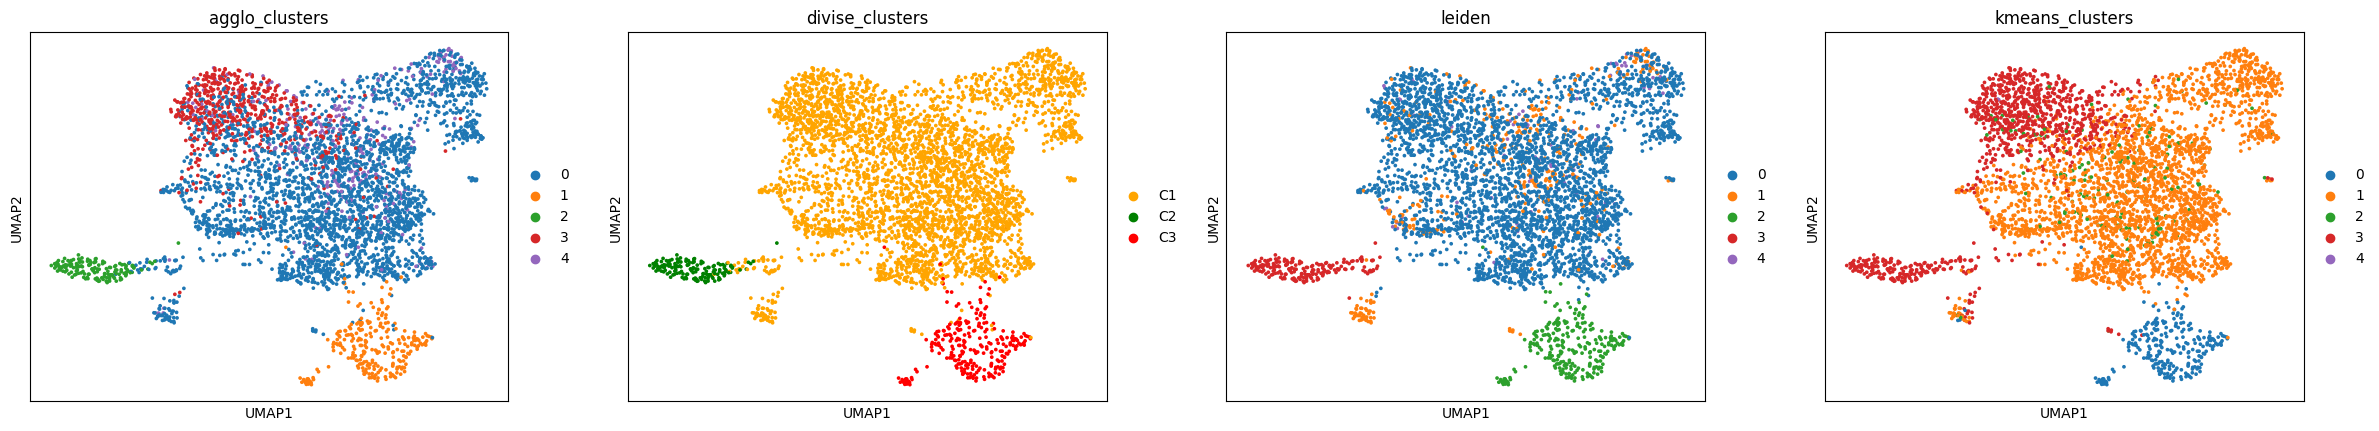

In [14]:
# Print different clusterings
sc.pl.umap(V1, color = ['agglo_clusters', 'divise_clusters', 'leiden', 'kmeans_clusters'])

In [15]:
from clustree import clustree
import networkx as nx

c:\Users\Emile\Documents\Polytechnique\4A\ParisSaclay\Stage\spinal_cross_species_V1\clustree.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  graph_layers.append([(i, np.sum([curr_clustering[j] == i for j in range(len(curr_clustering))])) for i in curr_clusters])
c:\Users\Emile\Documents\Polytechnique\4A\ParisSaclay\Stage\spinal_cross_species_V1\clustree.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  graph_layers.append([(i, np.sum([curr_clustering[j] == i for j in range(len(curr_clustering))])) for i in curr_clusters])
c:\Users\Emile\Documents\Polytechnique\4A\ParisSaclay\Stage\spinal_cross_species_V1\clus

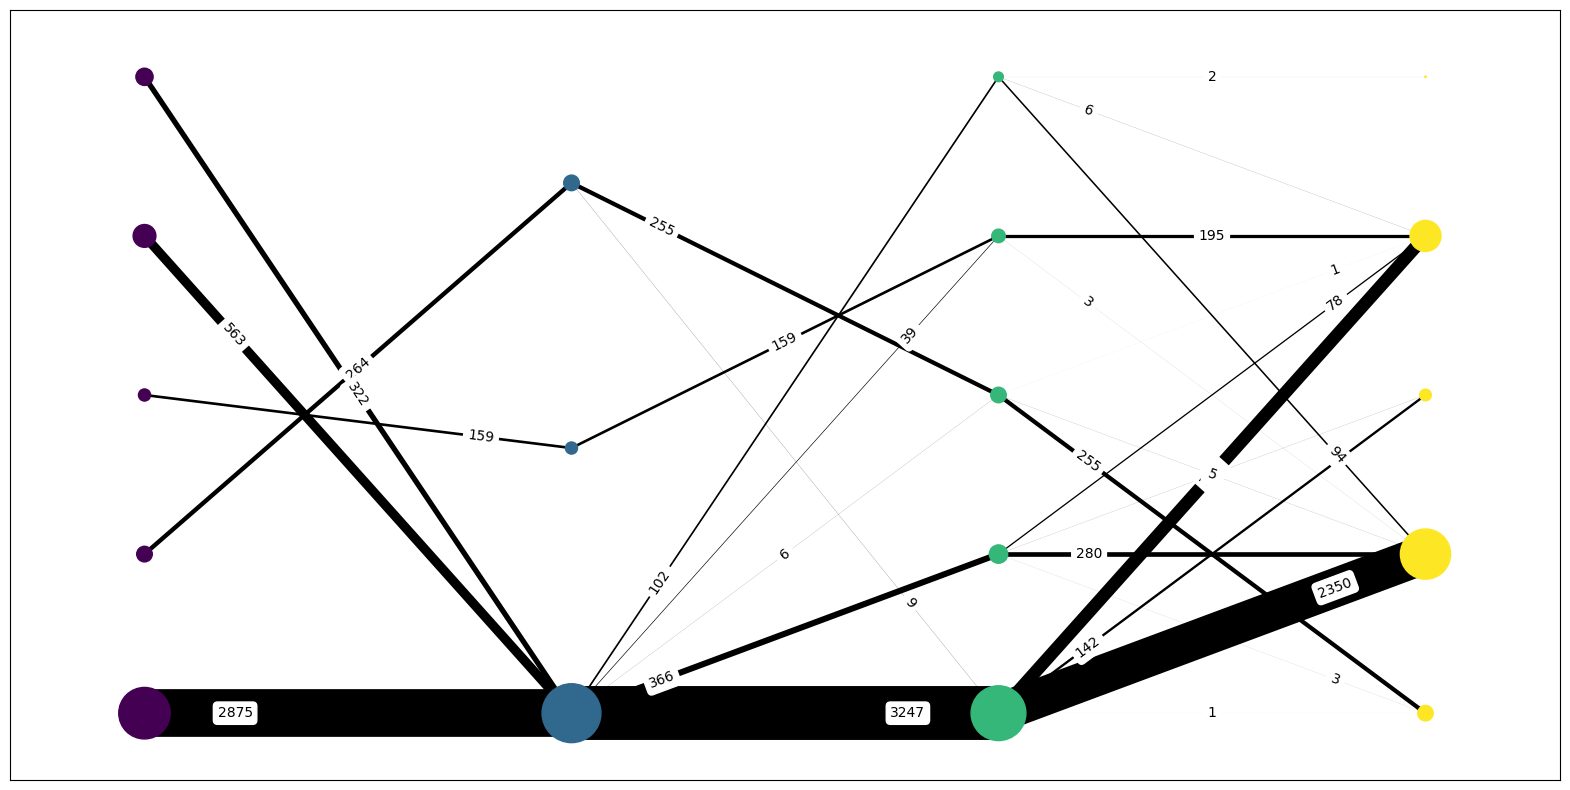

In [16]:
fig, ax = plt.subplots(1,1,figsize = (20,10))
G = clustree([V1.obs['agglo_clusters'].astype('int'), V1.obs['divise_clusters'].apply(lambda x : 0 if x == 'C1' else 1 if x == 'C2' else 2 if x == 'C3' else 3 if x == 'C4' else 4 ), V1.obs['leiden'].astype('int'), V1.obs['kmeans_clusters'].astype('int')], ax)

## Clustering using representation

In [17]:
from sklearn.cluster import AgglomerativeClustering
# Using the rpca representation for clustering
X = V1.obsm['X_rpca']

clustering = AgglomerativeClustering(n_clusters=5).fit(X)
V1.obs['agglo_clusters'] = clustering.labels_
V1.obs['agglo_clusters'] = V1.obs['agglo_clusters'].astype('category')

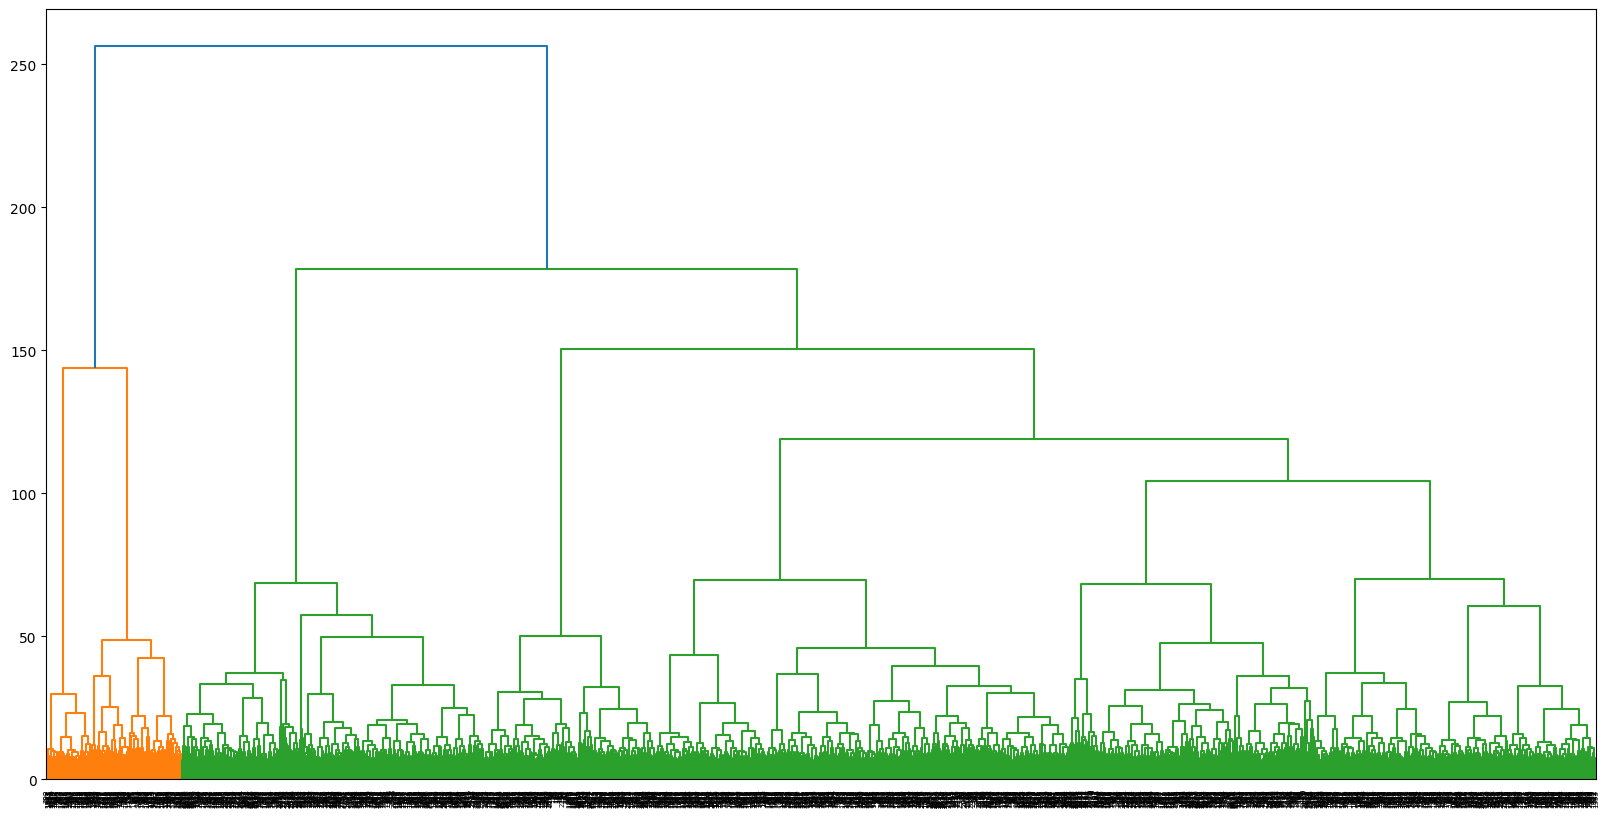

In [18]:
Z = hierarchy.linkage(X, 'ward')
fig, ax = plt.subplots(1,1, figsize = (20,10))
d = hierarchy.dendrogram(Z)

In [19]:
order = {}
for i in range(len(d['leaves'])):
    order[d['leaves'][i]] = d['leaves_color_list'][i]
res = {key: val for key, val in sorted(order.items(), key = lambda ele: ele[0])}
order = res

In [20]:
V1.uns['divise_clusters_colors'] = ['orange', 'green', 'red', 'violet']
V1.obs['divise_clusters'] = order.values()

In [21]:
from sklearn.cluster import KMeans
cluster_labels = KMeans(n_clusters=5, random_state=42).fit_predict(X)
V1.obs['kmeans_clusters'] = cluster_labels
V1.obs['kmeans_clusters'] = V1.obs['kmeans_clusters'].astype('category')

In [22]:
sc.neighbors.neighbors(V1, use_rep='X_rpca')
sc.tl.leiden(V1, resolution=0.1)

In [23]:

print('agglo clust: ', silhouette_score(V1.X, V1.obs['agglo_clusters']))
print('divise clust: ', silhouette_score(V1.X, V1.obs['divise_clusters']))
print('leiden: ', silhouette_score(V1.X, V1.obs['leiden']))
print('kmeans clust: ', silhouette_score(V1.X, V1.obs['kmeans_clusters']))

agglo clust:  0.008969455896304183
divise clust:  0.06333964283862493
leiden:  0.006789450574282207
kmeans clust:  0.0038534645546951453


In [24]:
print('agglo clust: ', silhouette_score(V1.obsm['X_rpca'], V1.obs['agglo_clusters']))
print('divise clust: ', silhouette_score(V1.obsm['X_rpca'], V1.obs['divise_clusters']))
print('leiden: ', silhouette_score(V1.obsm['X_rpca'], V1.obs['leiden']))
print('kmeans clust: ', silhouette_score(V1.obsm['X_rpca'], V1.obs['kmeans_clusters']))

agglo clust:  0.12504173721003647
divise clust:  0.3435103237060639
leiden:  0.13088265736784988
kmeans clust:  0.1422898952470445


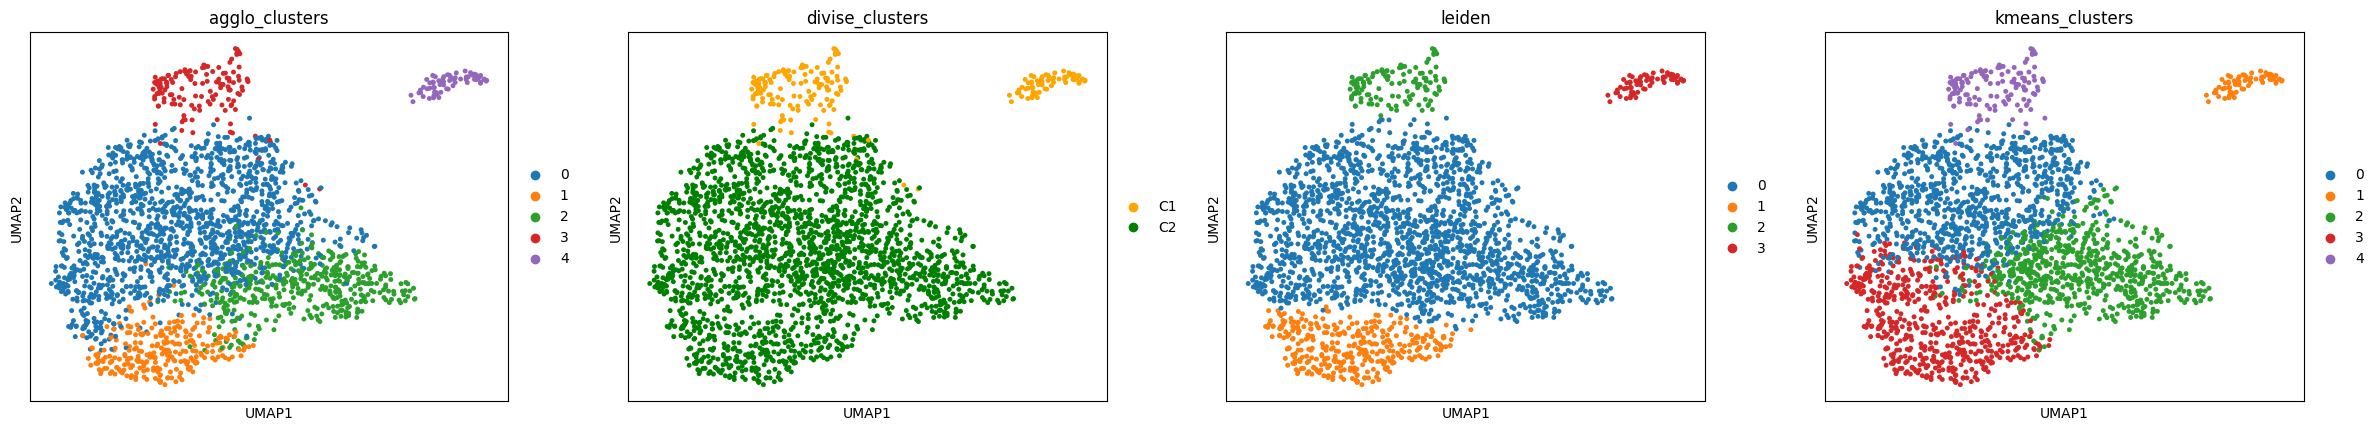

In [25]:
# Print different clusterings
sc.pl.umap(V1, color = ['agglo_clusters', 'divise_clusters', 'leiden', 'kmeans_clusters'])

c:\Users\Emile\Documents\Polytechnique\4A\ParisSaclay\Stage\spinal_cross_species_V1\clustree.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  graph_layers.append([(i, np.sum([curr_clustering[j] == i for j in range(len(curr_clustering))])) for i in curr_clusters])
c:\Users\Emile\Documents\Polytechnique\4A\ParisSaclay\Stage\spinal_cross_species_V1\clustree.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  graph_layers.append([(i, np.sum([curr_clustering[j] == i for j in range(len(curr_clustering))])) for i in curr_clusters])
c:\Users\Emile\Documents\Polytechnique\4A\ParisSaclay\Stage\spinal_cross_species_V1\clus

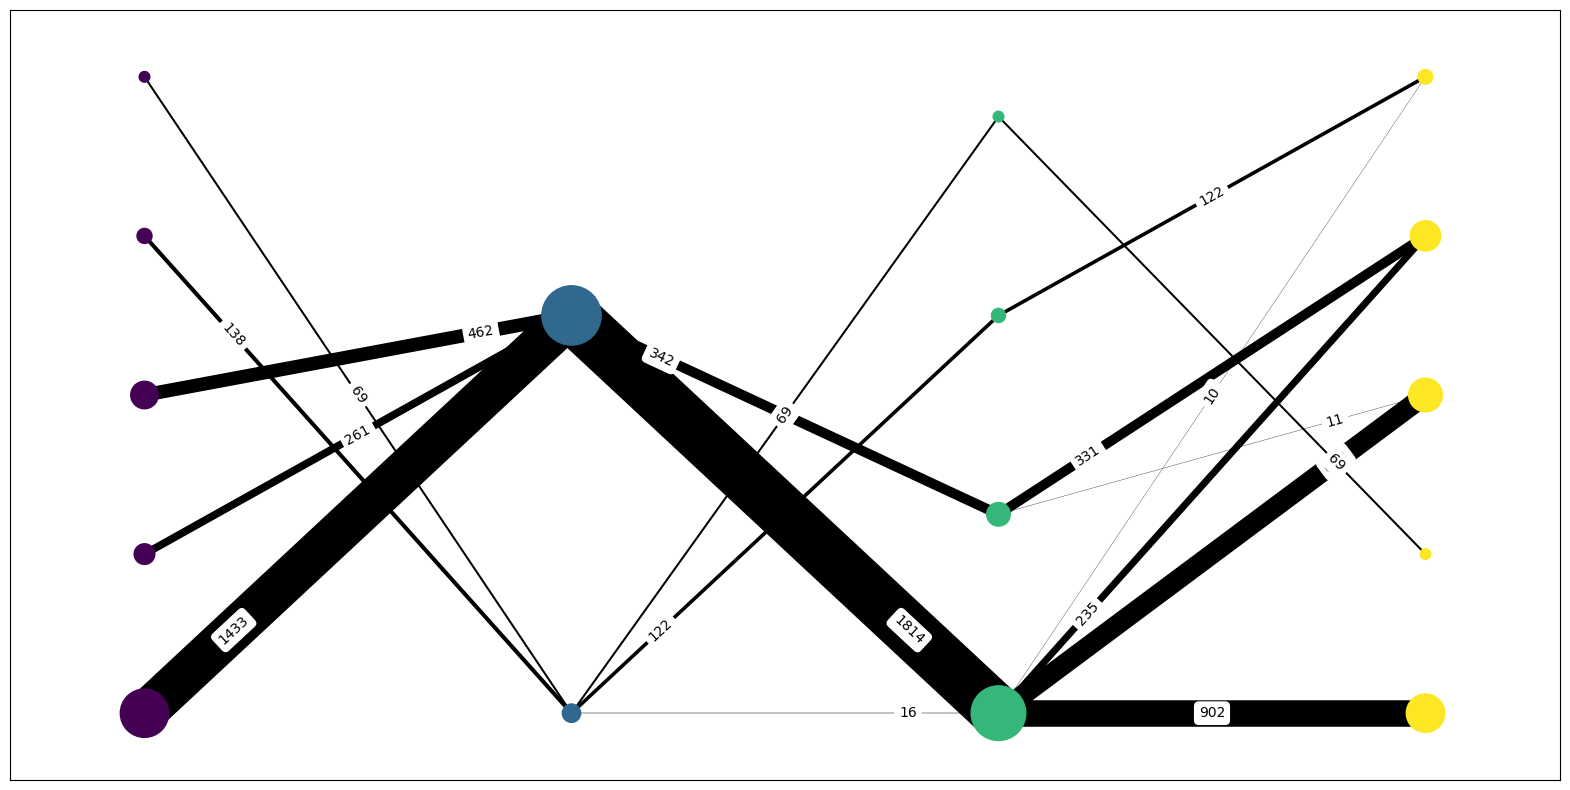

In [26]:
fig, ax = plt.subplots(1,1,figsize = (20,10))
G = clustree([V1.obs['agglo_clusters'].astype('int'), V1.obs['divise_clusters'].apply(lambda x : 0 if x == 'C1' else 1 if x == 'C2' else 2 if x == 'C3' else 3 if x == 'C4' else 4 ), V1.obs['leiden'].astype('int'), V1.obs['kmeans_clusters'].astype('int')], ax)

## Resolution analysis

Leiden with resolution:  0.05
Leiden with resolution:  0.33749999999999997
Leiden with resolution:  0.625
Leiden with resolution:  0.9125
Leiden with resolution:  1.2


c:\Users\Emile\Documents\Polytechnique\4A\ParisSaclay\Stage\spinal_cross_species_V1\clustree.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  graph_layers.append([(i, np.sum([curr_clustering[j] == i for j in range(len(curr_clustering))])) for i in curr_clusters])
c:\Users\Emile\Documents\Polytechnique\4A\ParisSaclay\Stage\spinal_cross_species_V1\clustree.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  graph_layers.append([(i, np.sum([curr_clustering[j] == i for j in range(len(curr_clustering))])) for i in curr_clusters])
c:\Users\Emile\Documents\Polytechnique\4A\ParisSaclay\Stage\spinal_cross_species_V1\clus

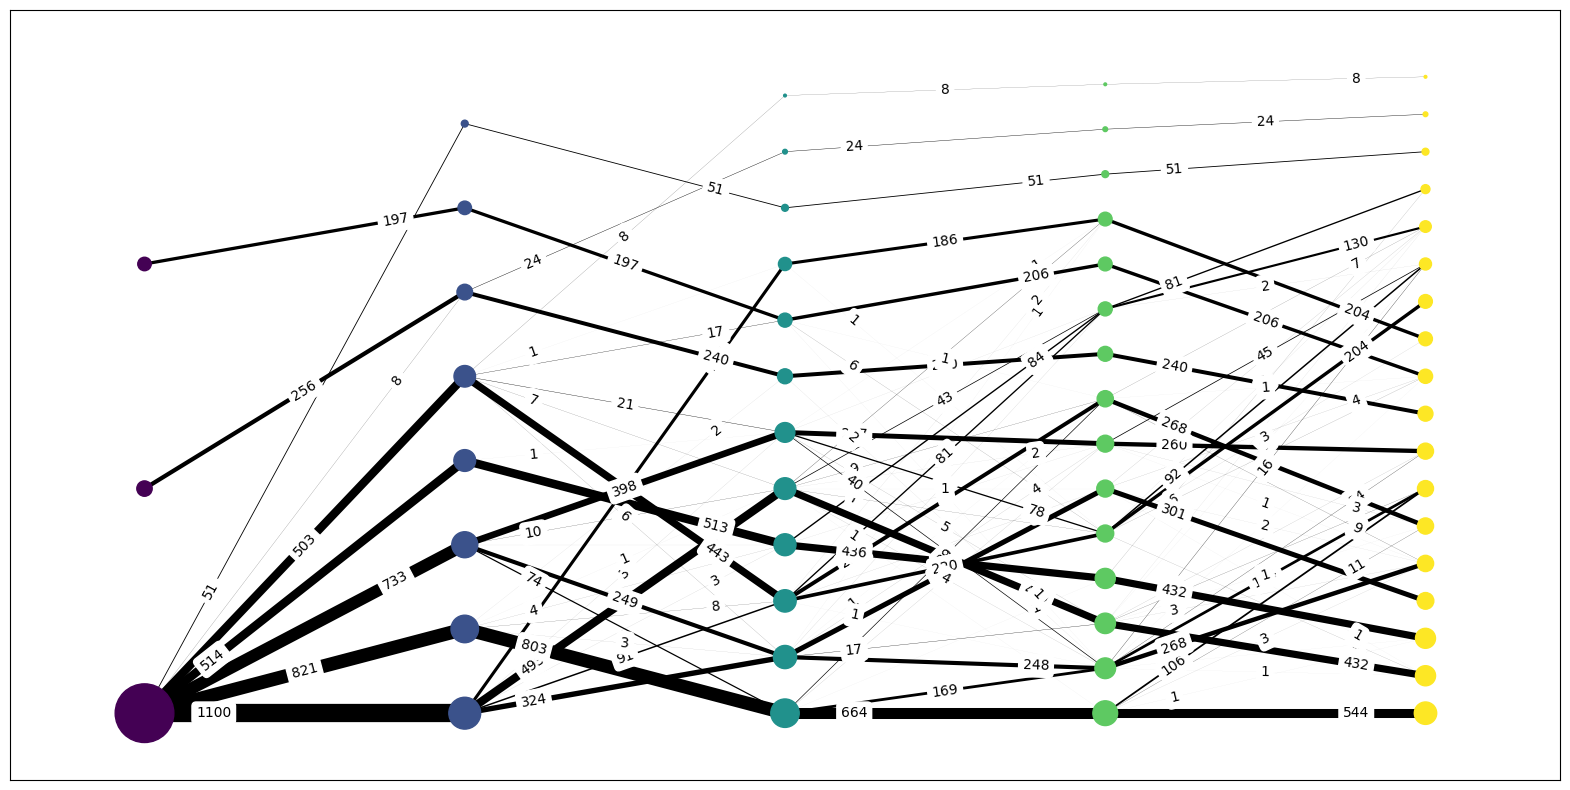

In [17]:
fig, ax = plt.subplots(1,1,figsize = (20,10))
resolutions = np.linspace(0.05, 1.2,5)
sc.pp.neighbors(V1, use_rep='X_rpca')
sc.tl.umap(V1)
clusterings = []
for r in resolutions:
    print('Leiden with resolution: ', r)
    sc.tl.leiden(V1, resolution=r)
    clusterings.append(V1.obs['leiden'].astype('int'))
G, pos = clustree(clusterings, ax)

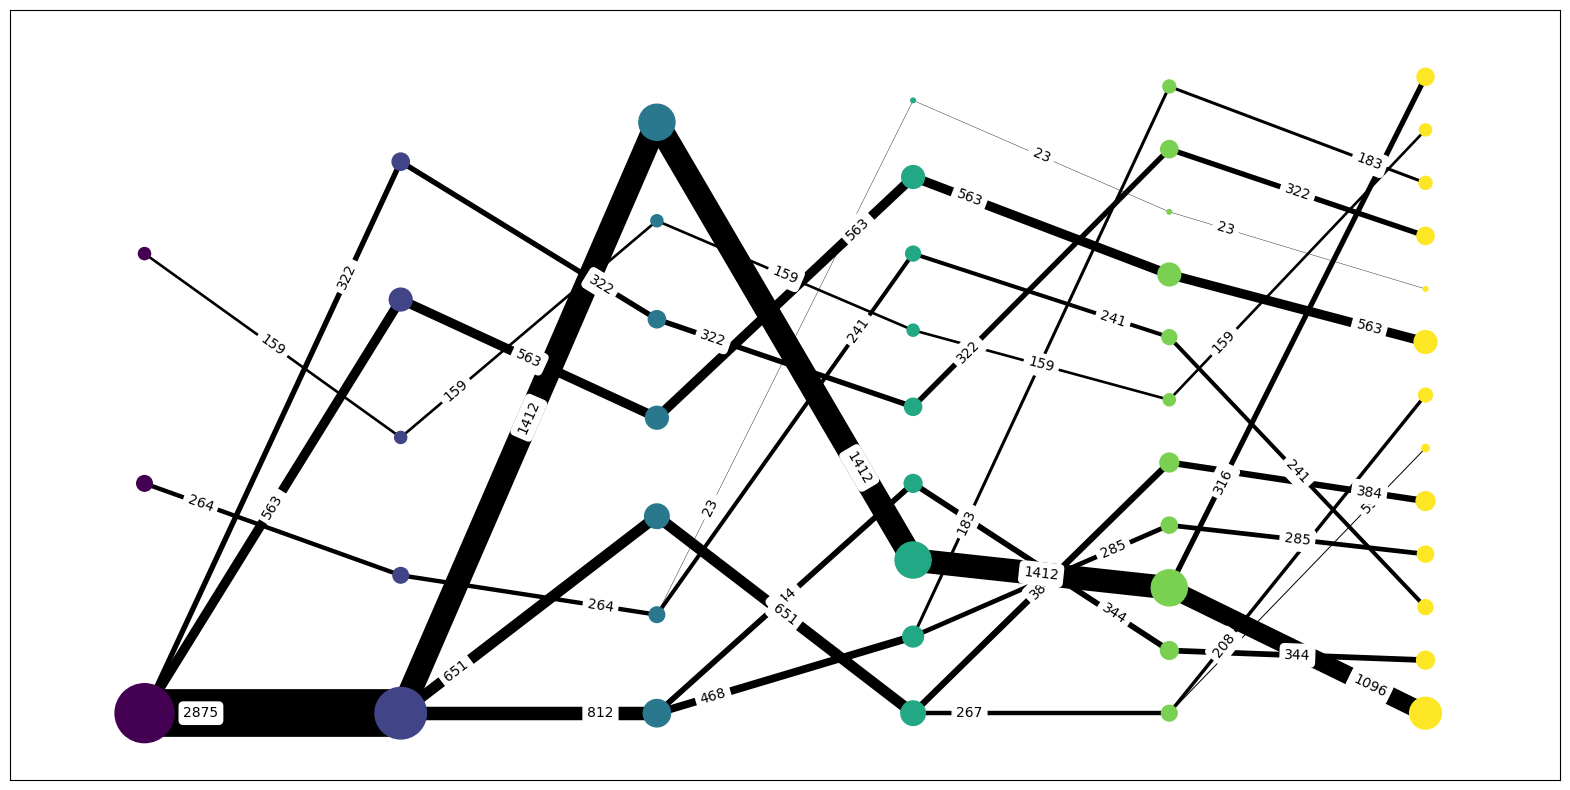

In [18]:
fig, ax = plt.subplots(1,1,figsize = (20,10))
n_clusters = range(3,15,2)
clusterings = []
for n in n_clusters:
    clustering = AgglomerativeClustering(n_clusters=n).fit(X)
    clusterings.append(clustering.labels_)
G, pos = clustree(clusterings, ax)

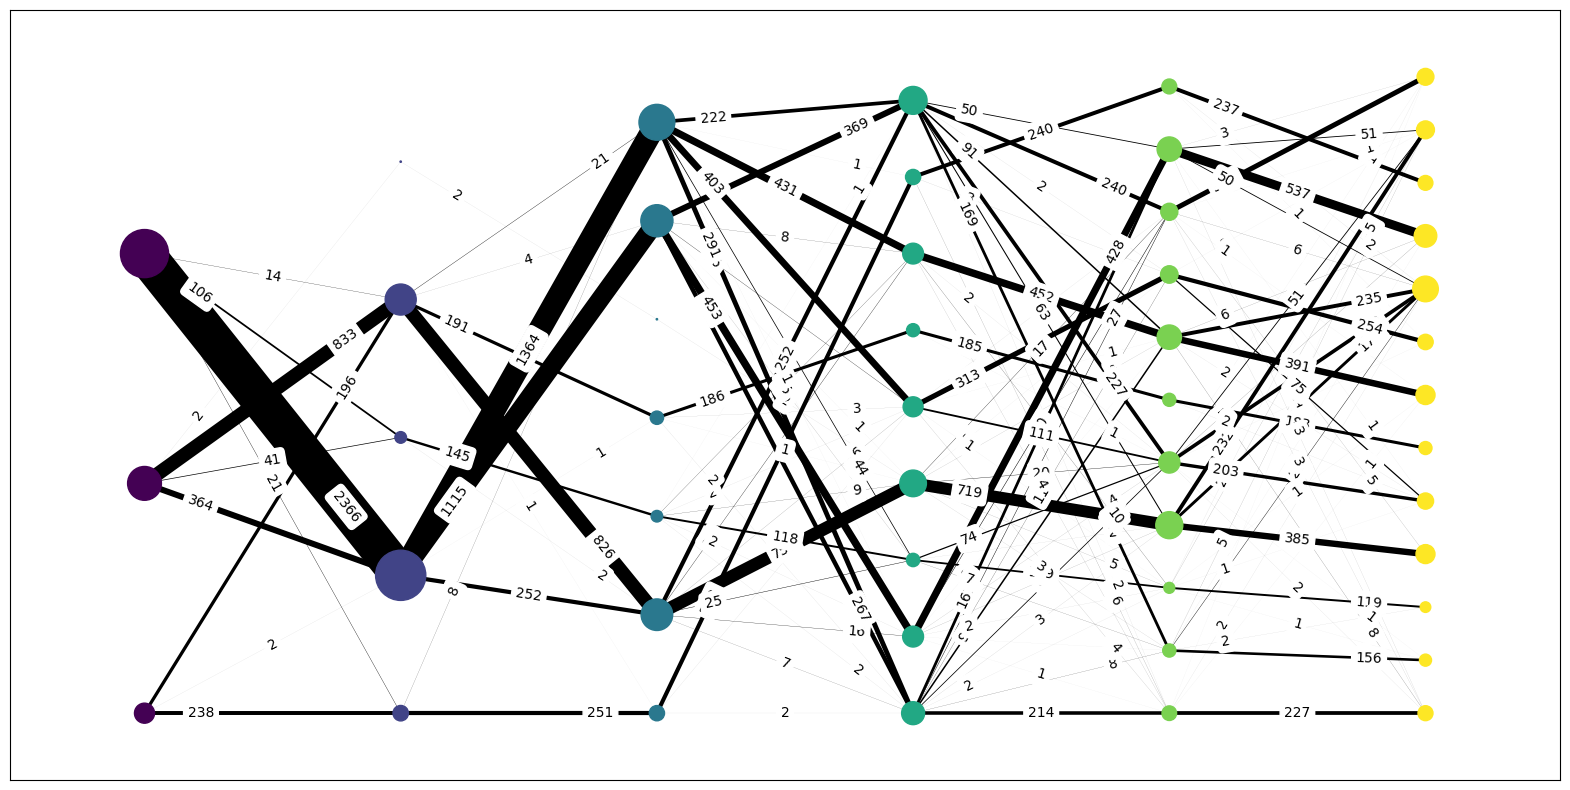

In [19]:
fig, ax = plt.subplots(1,1,figsize = (20,10))
n_clusters = range(3,15,2)
clusterings = []
for n in n_clusters:
    cluster_labels = KMeans(n_clusters=n, random_state=42).fit_predict(X)
    clusterings.append(cluster_labels)
G, pos = clustree(clusterings, ax)

## Analysis

In [20]:
# Explore marker representation in these clusters
mouse_counts = sc.read_h5ad('data/origin_data/mouse_neurons_counts+skinnider+knaf14.h5ad')

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'data/origin_data/mouse_neurons_counts+skinnider+knaf14.h5ad', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [29]:
mouse_counts.obs['v1'] = mouse_annotation.obs['v1']

In [20]:
mouse_counts = mouse_counts[mouse_counts.obs['v1'].notna()]

In [21]:
V1_counts = mouse_counts[mouse_counts.obs['v1'] == 'V1']
V1_counts

View of AnnData object with n_obs × n_vars = 2363 × 32285
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'doublet_finder', 'percent_mito', 'keep', 'nCount_SCT', 'nFeature_SCT', 'GFP', 'seurat_clusters', 'celltype', 'SCT_snn_res.0.05', 'SCT_snn_res.1.5', 'v1'

In [22]:
V1_counts.obs['divise_clusters'] = V1.obs['divise_clusters']

C:\Users\Emile\AppData\Local\Temp\ipykernel_16312\2717641760.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  V1_counts.obs['divise_clusters'] = V1.obs['divise_clusters']


In [23]:
sc.pp.log1p(V1_counts, copy=False)

In [24]:
sc.tl.rank_genes_groups(V1_counts, groupby='divise_clusters', method = 'wilcoxon', tie_correct=True)

c:\Users\Emile\AppData\Local\Programs\Python\Python313\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:357: RuntimeWarning: invalid value encountered in divide
  scores[group_index, :] = (
c:\Users\Emile\AppData\Local\Programs\Python\Python313\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:357: RuntimeWarning: invalid value encountered in divide
  scores[group_index, :] = (
c:\Users\Emile\AppData\Local\Programs\Python\Python313\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:357: RuntimeWarning: invalid value encountered in divide
  scores[group_index, :] = (
c:\Users\Emile\AppData\Local\Programs\Python\Python313\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:357: RuntimeWarning: invalid value encountered in divide
  scores[group_index, :] = (
c:\Users\Emile\AppData\Local\Programs\Python\Python313\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:357: RuntimeWarning: invalid value encountered in divide
  scores[group_index, :] = (


c:\Users\Emile\AppData\Local\Programs\Python\Python313\Lib\site-packages\scanpy\tools\_utils.py:40: UserWarning: You’re trying to run this on 32285 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


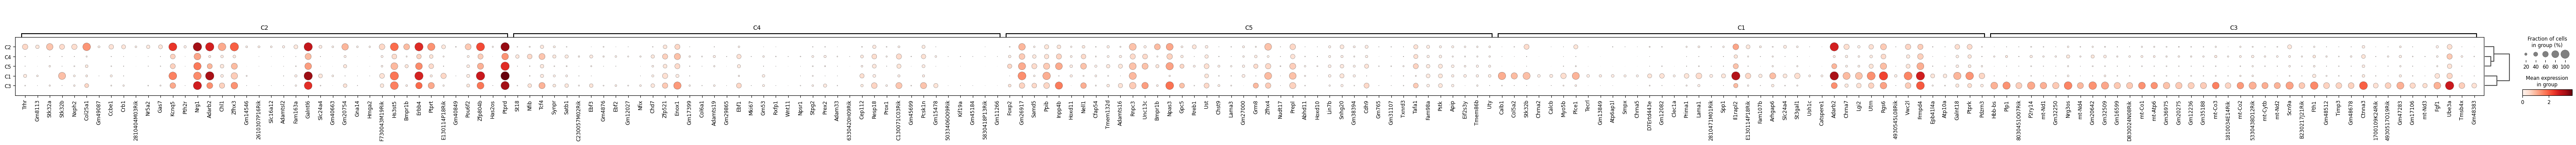

In [25]:
sc.pl.rank_genes_groups_dotplot(V1_counts, n_genes=40)

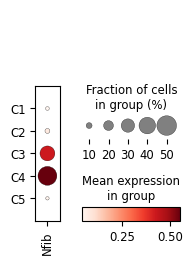

In [26]:
sc.pl.dotplot(V1_counts, ['Nfib'], groupby='divise_clusters')

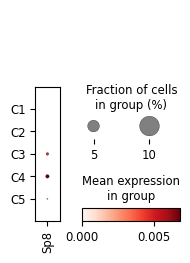

In [27]:
sc.pl.dotplot(V1_counts, ['Sp8'], groupby='divise_clusters')

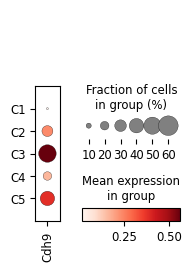

In [28]:
sc.pl.dotplot(V1_counts, ['Cdh9'], groupby='divise_clusters')

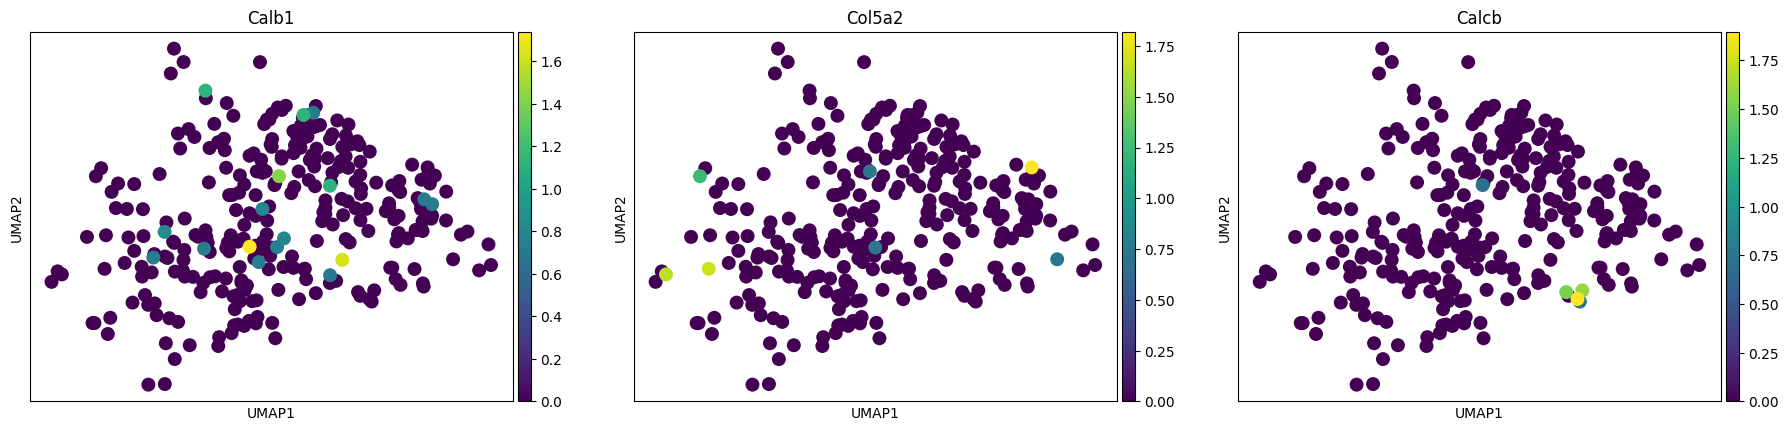

In [29]:
sc.pl.umap(V1[V1.obs['divise_clusters'] == 'C3'], color = ['Calb1', 'Col5a2', 'Calcb'])

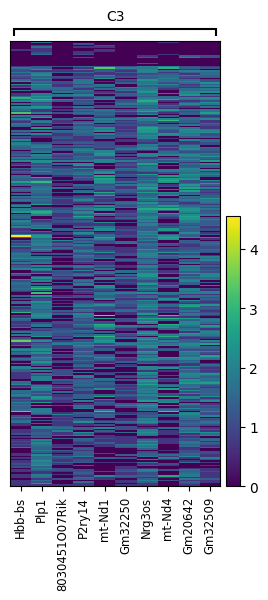

In [30]:
sc.pl.rank_genes_groups_heatmap(V1_counts[V1_counts.obs['divise_clusters'] == 'C3'], groups= ['C3'])

In [31]:
marker_genes = {'C3': ['Calb1', 'Col5a2', 'Plce1'],
                'C1' : ['Foxp2', 'Cdh9', 'Unc13c', 'Slit2', 'L3mbtl4']
}

In [32]:
sc.tl.marker_gene_overlap(V1_counts, marker_genes, method='jaccard')

C1        C2   C3   C4        C5
C3  0.03  0.009804  0.0  0.0  0.000000
C1  0.00  0.000000  0.0  0.0  0.029412

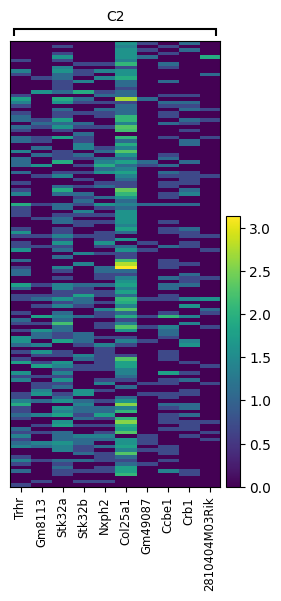

In [33]:
sc.pl.rank_genes_groups_heatmap(V1_counts[V1_counts.obs['divise_clusters'] == 'C2'], groups= ['C2'])

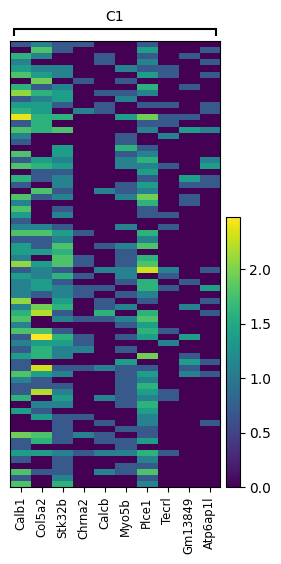

In [34]:
sc.pl.rank_genes_groups_heatmap(V1_counts[V1_counts.obs['divise_clusters'] == 'C1'], groups= ['C1'])

In [35]:
C1_marker_genes = ['Foxp2', 'Cdh9', 'Essrg']

In [36]:
V1_counts.obs['agglo_clusters'] = V1.obs['agglo_clusters'].apply(lambda x : str(x))

In [37]:
V1.obs['agglo_clusters'] = V1.obs['agglo_clusters'].astype('category')

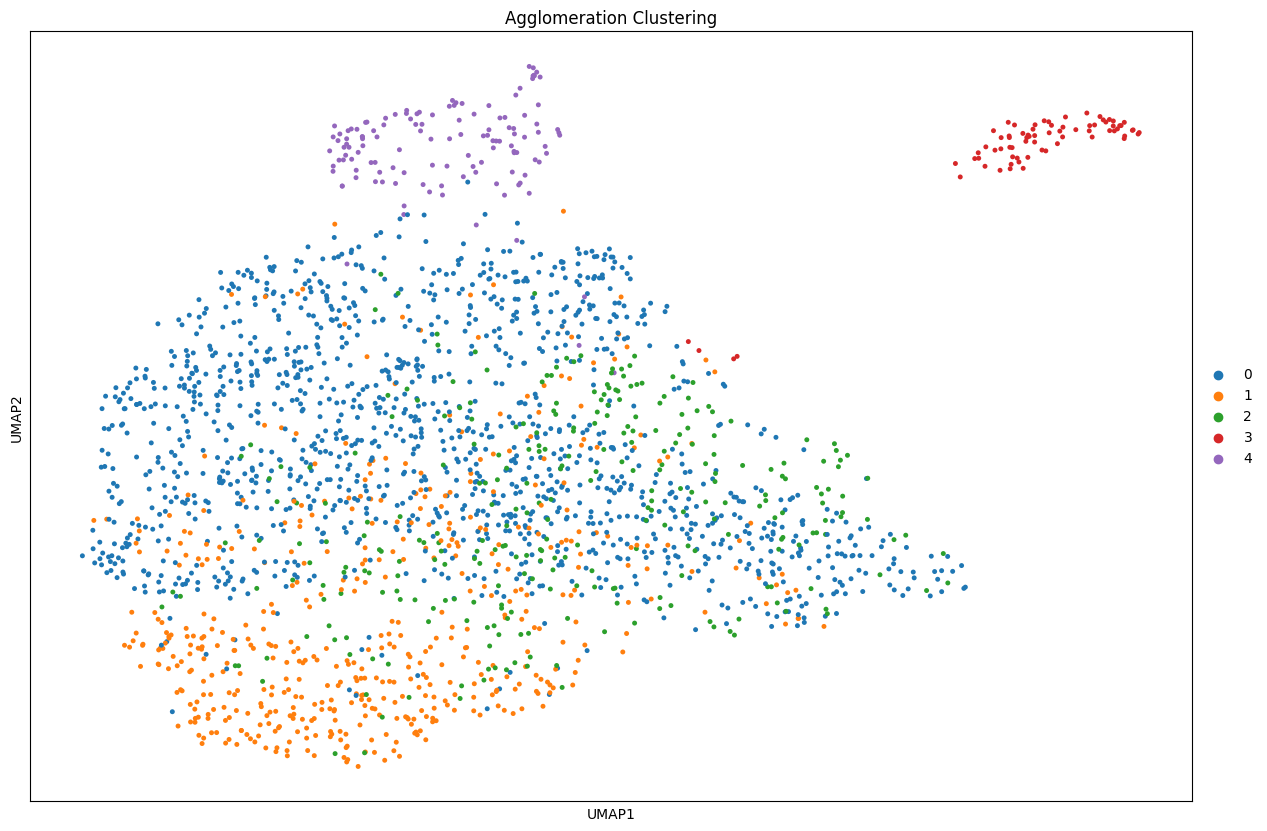

In [38]:
fig, ax = plt.subplots(1,1,figsize = (15,10))
sc.pl.umap(V1, color='agglo_clusters', title='Agglomeration Clustering', ax =ax)

In [39]:
V1_counts.obs['agglo_clusters'] = V1_counts.obs['agglo_clusters'].astype('category')

In [40]:
sc.tl.dendrogram(V1_counts, groupby='agglo_clusters')

In [41]:
sc.tl.rank_genes_groups(V1_counts, groupby='agglo_clusters', method = 'wilcoxon', tie_correct=True)

c:\Users\Emile\AppData\Local\Programs\Python\Python313\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:357: RuntimeWarning: invalid value encountered in divide
  scores[group_index, :] = (
c:\Users\Emile\AppData\Local\Programs\Python\Python313\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:357: RuntimeWarning: invalid value encountered in divide
  scores[group_index, :] = (
c:\Users\Emile\AppData\Local\Programs\Python\Python313\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:357: RuntimeWarning: invalid value encountered in divide
  scores[group_index, :] = (
c:\Users\Emile\AppData\Local\Programs\Python\Python313\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:357: RuntimeWarning: invalid value encountered in divide
  scores[group_index, :] = (
c:\Users\Emile\AppData\Local\Programs\Python\Python313\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:357: RuntimeWarning: invalid value encountered in divide
  scores[group_index, :] = (


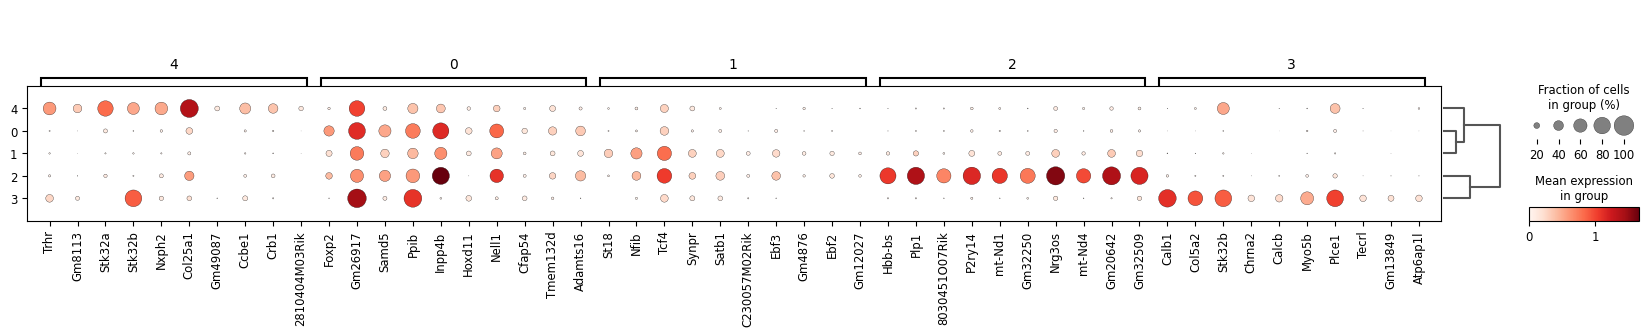

In [42]:
sc.pl.rank_genes_groups_dotplot(V1_counts)

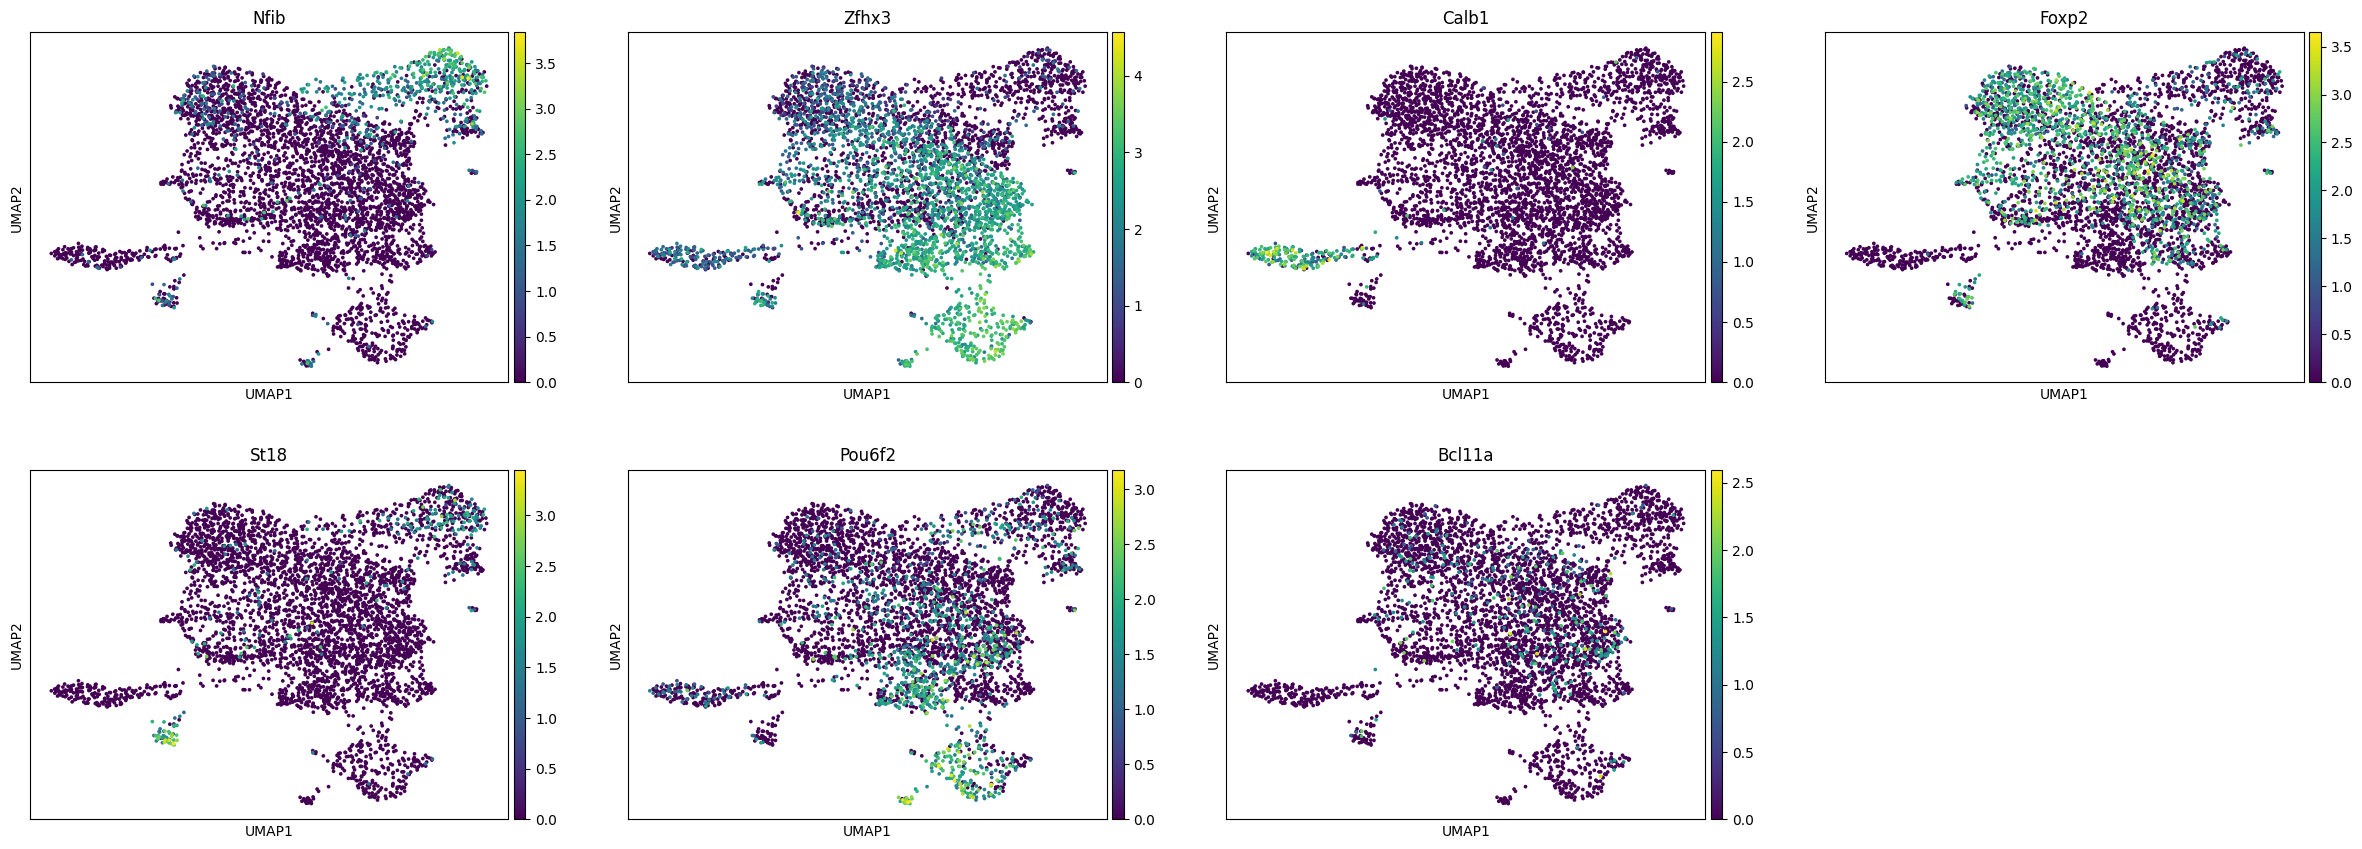

In [21]:
discr_genes =  ['Nfib', 'Zfhx3', 'Calb1', 'Foxp2', 'St18', 'Pou6f2', 'Bcl11a']

sc.pl.umap(V1, color = discr_genes)

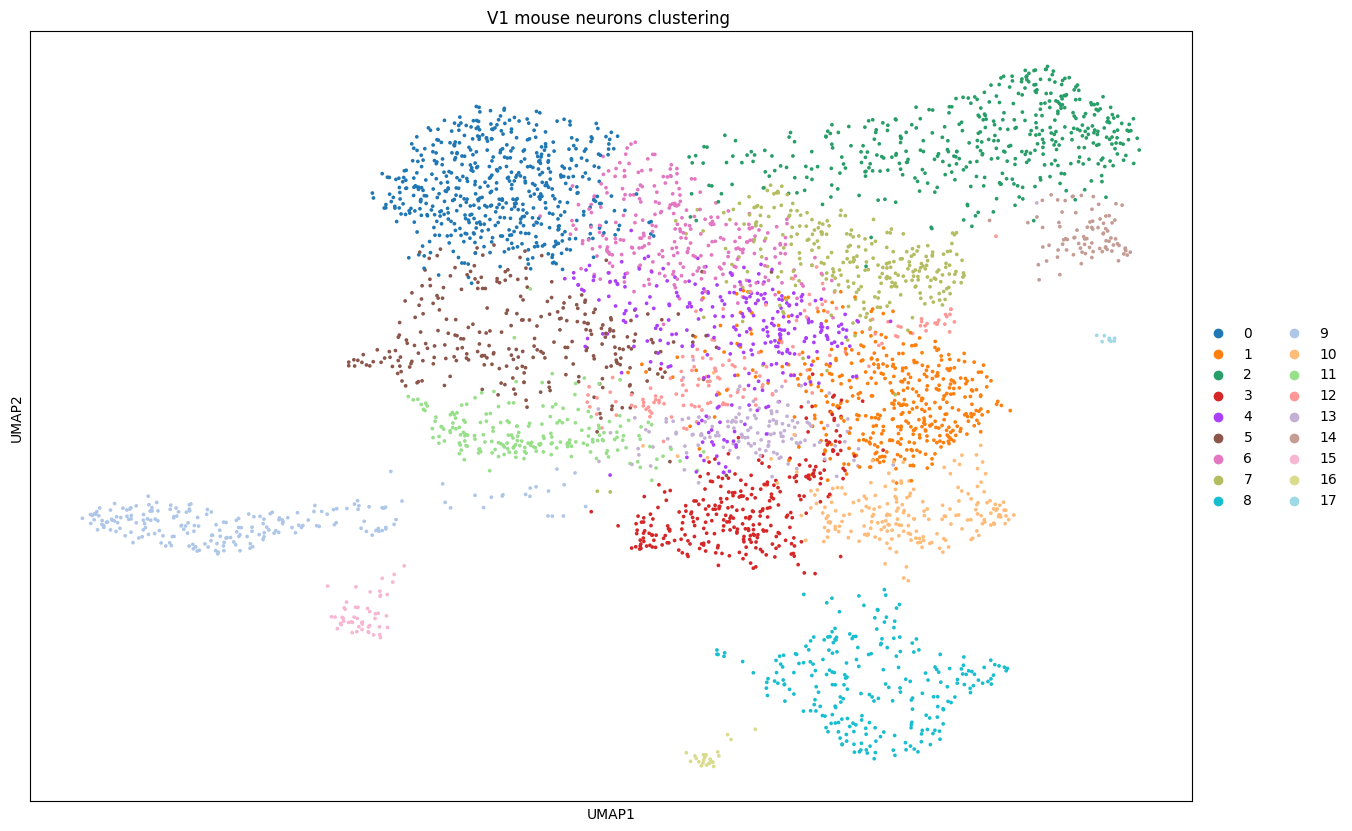

In [22]:
fig, ax = plt.subplots(1,1, figsize = (15,10))
sc.pl.umap(V1, color='leiden', ax =ax, title='V1 mouse neurons clustering ')

In [23]:
V1

AnnData object with n_obs × n_vars = 4183 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'species', 'doublet_finder', 'percent_mito', 'keep', 'nCount_SCT', 'nFeature_SCT', 'GFP', 'RNA_snn_res.2', 'seurat_clusters', 'training_labels', 'citeseq', 'annotation', 'labels_xgb', 'v1', 'agglo_clusters', 'divise_clusters', 'kmeans_clusters', 'leiden'
    var: 'vf_vst_counts.BOUV5_mean', 'vf_vst_counts.BOUV5_variance', 'vf_vst_counts.BOUV5_variance.expected', 'vf_vst_counts.BOUV5_variance.standardized', 'vf_vst_counts.BOUV5_variable', 'vf_vst_counts.BOUV5_rank', 'vf_vst_counts.KATHE_mean', 'vf_vst_counts.KATHE_variance', 'vf_vst_counts.KATHE_variance.expected', 'vf_vst_counts.KATHE_variance.standardized', 'vf_vst_counts.KATHE_variable', 'vf_vst_counts.KATHE_rank', 'vf_vst_counts.MATSON_mean', 'vf_vst_counts.MATSON_variance', 'vf_vst_counts.MATSON_variance.expected', 'vf_vst_counts.MATSON_variance.standardized', 'vf_vst_counts.MATSON_variable', 'vf_vst_counts.MATSON_rank', 'vf_vst_co

In [24]:
V1

AnnData object with n_obs × n_vars = 4183 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'species', 'doublet_finder', 'percent_mito', 'keep', 'nCount_SCT', 'nFeature_SCT', 'GFP', 'RNA_snn_res.2', 'seurat_clusters', 'training_labels', 'citeseq', 'annotation', 'labels_xgb', 'v1', 'agglo_clusters', 'divise_clusters', 'kmeans_clusters', 'leiden'
    var: 'vf_vst_counts.BOUV5_mean', 'vf_vst_counts.BOUV5_variance', 'vf_vst_counts.BOUV5_variance.expected', 'vf_vst_counts.BOUV5_variance.standardized', 'vf_vst_counts.BOUV5_variable', 'vf_vst_counts.BOUV5_rank', 'vf_vst_counts.KATHE_mean', 'vf_vst_counts.KATHE_variance', 'vf_vst_counts.KATHE_variance.expected', 'vf_vst_counts.KATHE_variance.standardized', 'vf_vst_counts.KATHE_variable', 'vf_vst_counts.KATHE_rank', 'vf_vst_counts.MATSON_mean', 'vf_vst_counts.MATSON_variance', 'vf_vst_counts.MATSON_variance.expected', 'vf_vst_counts.MATSON_variance.standardized', 'vf_vst_counts.MATSON_variable', 'vf_vst_counts.MATSON_rank', 'vf_vst_co

In [25]:
sc.tl.rank_genes_groups(V1, method='wilcoxon', groupby='leiden')

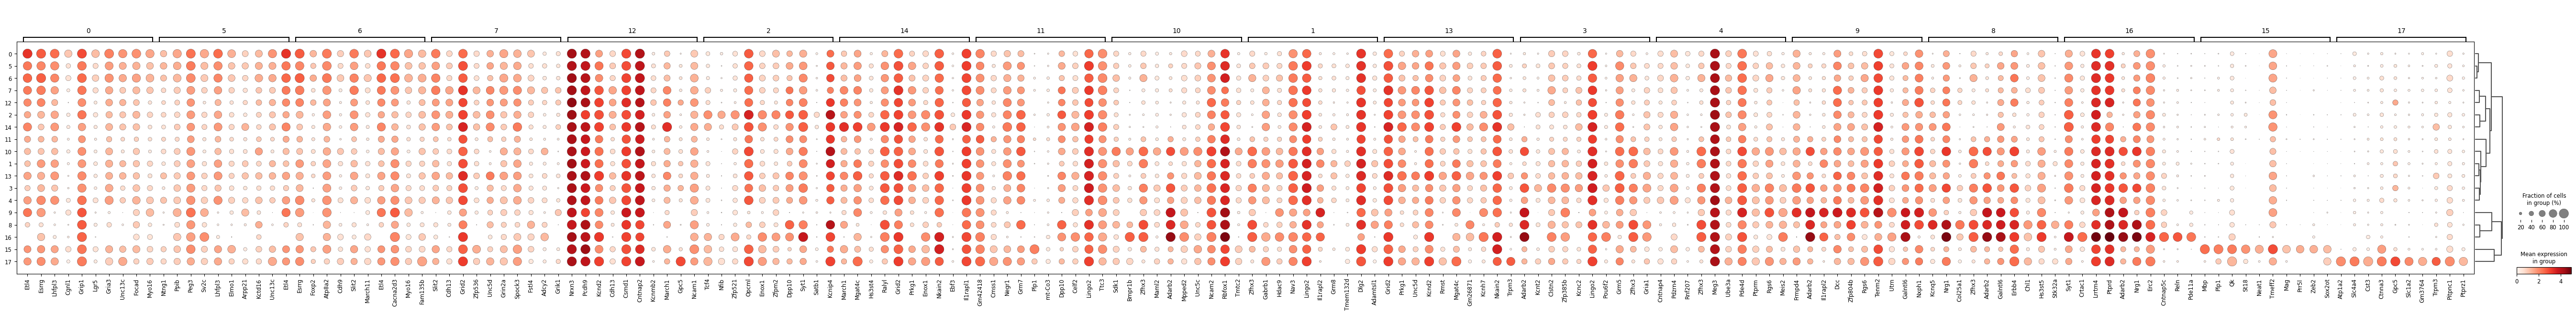

In [26]:
sc.pl.rank_genes_groups_dotplot(V1, groupby='leiden')

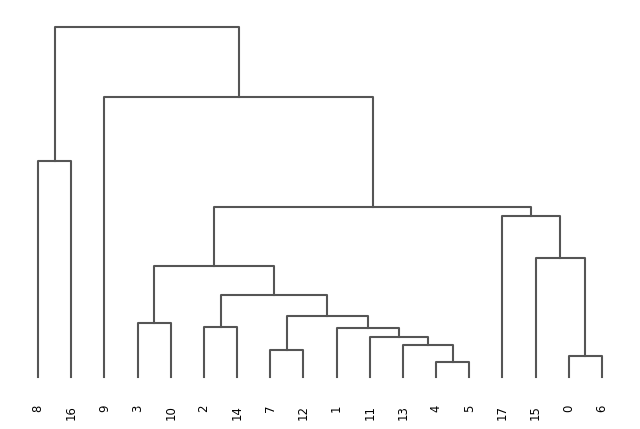

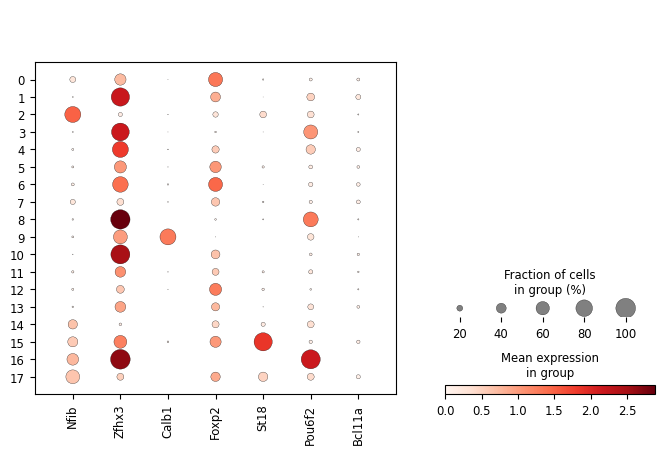

In [27]:
sc.tl.dendrogram(V1, groupby= 'leiden', var_names=discr_genes)
fig, ax = plt.subplots(1,1,figsize = (8,5))
sc.pl.dendrogram(V1, groupby='leiden', ax = ax)
fig, ax = plt.subplots(1,1,figsize = (8,5))
sc.pl.dotplot(V1, discr_genes, groupby='leiden', ax = ax)

In [42]:
sc.tl.leiden(V1, resolution=1)

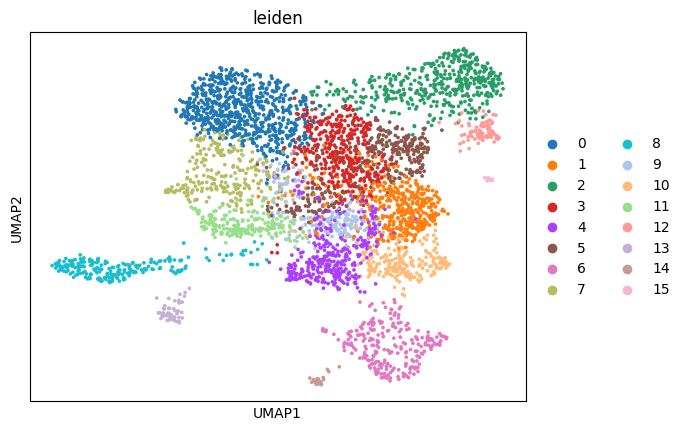

In [43]:
sc.pl.umap(V1, color = 'leiden')

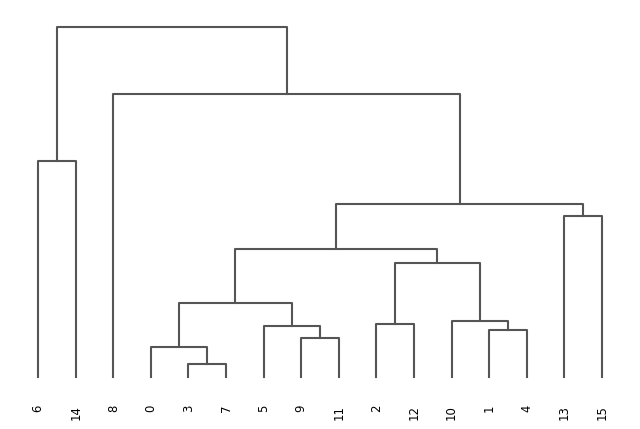

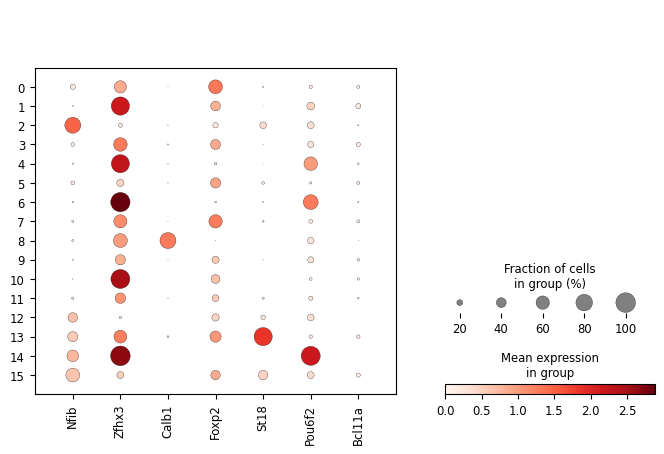

In [44]:
sc.tl.dendrogram(V1, groupby= 'leiden', var_names=discr_genes)
fig, ax = plt.subplots(1,1,figsize = (8,5))
sc.pl.dendrogram(V1, groupby='leiden', ax = ax)
fig, ax = plt.subplots(1,1,figsize = (8,5))
sc.pl.dotplot(V1, discr_genes, groupby='leiden', ax = ax)

# Human Clustering

In [2]:
human_annotation_file = 'data/annotated_data/human_neurons_annotated_human_augmented+KNAF12.h5ad'
human_annotation = sc.read_h5ad(human_annotation_file)
human_annotation

AnnData object with n_obs × n_vars = 31931 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'species', 'doublet_finder', 'percent_mito', 'keep', 'RNA_snn_res.2', 'seurat_clusters', 'training_labels', 'labels_xgb', 'annotation', 'predicted_labels_xgb', 'predicted_annotation'
    var: 'vf_vst_counts.KNAF3_mean', 'vf_vst_counts.KNAF3_variance', 'vf_vst_counts.KNAF3_variance.expected', 'vf_vst_counts.KNAF3_variance.standardized', 'vf_vst_counts.KNAF3_variable', 'vf_vst_counts.KNAF3_rank', 'vf_vst_counts.KNAF4_mean', 'vf_vst_counts.KNAF4_variance', 'vf_vst_counts.KNAF4_variance.expected', 'vf_vst_counts.KNAF4_variance.standardized', 'vf_vst_counts.KNAF4_variable', 'vf_vst_counts.KNAF4_rank', 'vf_vst_counts.KNAF8_mean', 'vf_vst_counts.KNAF8_variance', 'vf_vst_counts.KNAF8_variance.expected', 'vf_vst_counts.KNAF8_variance.standardized', 'vf_vst_counts.KNAF8_variable', 'vf_vst_counts.KNAF8_rank', 'vf_vst_counts.KNAF9_mean', 'vf_vst_counts.KNAF9_variance', 'vf_vst_counts.KNAF9_varian

In [3]:
human_annotation = human_annotation[human_annotation.obs['species'] == 'human']

In [4]:
human_annotation.obs['predicted_annotation'].value_counts()

predicted_annotation
Not_V1_predicted    26428
V1_predicted          418
Name: count, dtype: int64

In [5]:
V1_human = human_annotation[human_annotation.obs['predicted_annotation'] == 'V1_predicted']
V1_human

View of AnnData object with n_obs × n_vars = 418 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'species', 'doublet_finder', 'percent_mito', 'keep', 'RNA_snn_res.2', 'seurat_clusters', 'training_labels', 'labels_xgb', 'annotation', 'predicted_labels_xgb', 'predicted_annotation'
    var: 'vf_vst_counts.KNAF3_mean', 'vf_vst_counts.KNAF3_variance', 'vf_vst_counts.KNAF3_variance.expected', 'vf_vst_counts.KNAF3_variance.standardized', 'vf_vst_counts.KNAF3_variable', 'vf_vst_counts.KNAF3_rank', 'vf_vst_counts.KNAF4_mean', 'vf_vst_counts.KNAF4_variance', 'vf_vst_counts.KNAF4_variance.expected', 'vf_vst_counts.KNAF4_variance.standardized', 'vf_vst_counts.KNAF4_variable', 'vf_vst_counts.KNAF4_rank', 'vf_vst_counts.KNAF8_mean', 'vf_vst_counts.KNAF8_variance', 'vf_vst_counts.KNAF8_variance.expected', 'vf_vst_counts.KNAF8_variance.standardized', 'vf_vst_counts.KNAF8_variable', 'vf_vst_counts.KNAF8_rank', 'vf_vst_counts.KNAF9_mean', 'vf_vst_counts.KNAF9_variance', 'vf_vst_counts.KNAF9_

In [6]:
sc.neighbors.neighbors(V1_human, use_rep='X_rpca')

In [7]:
sc.tl.umap(V1_human)

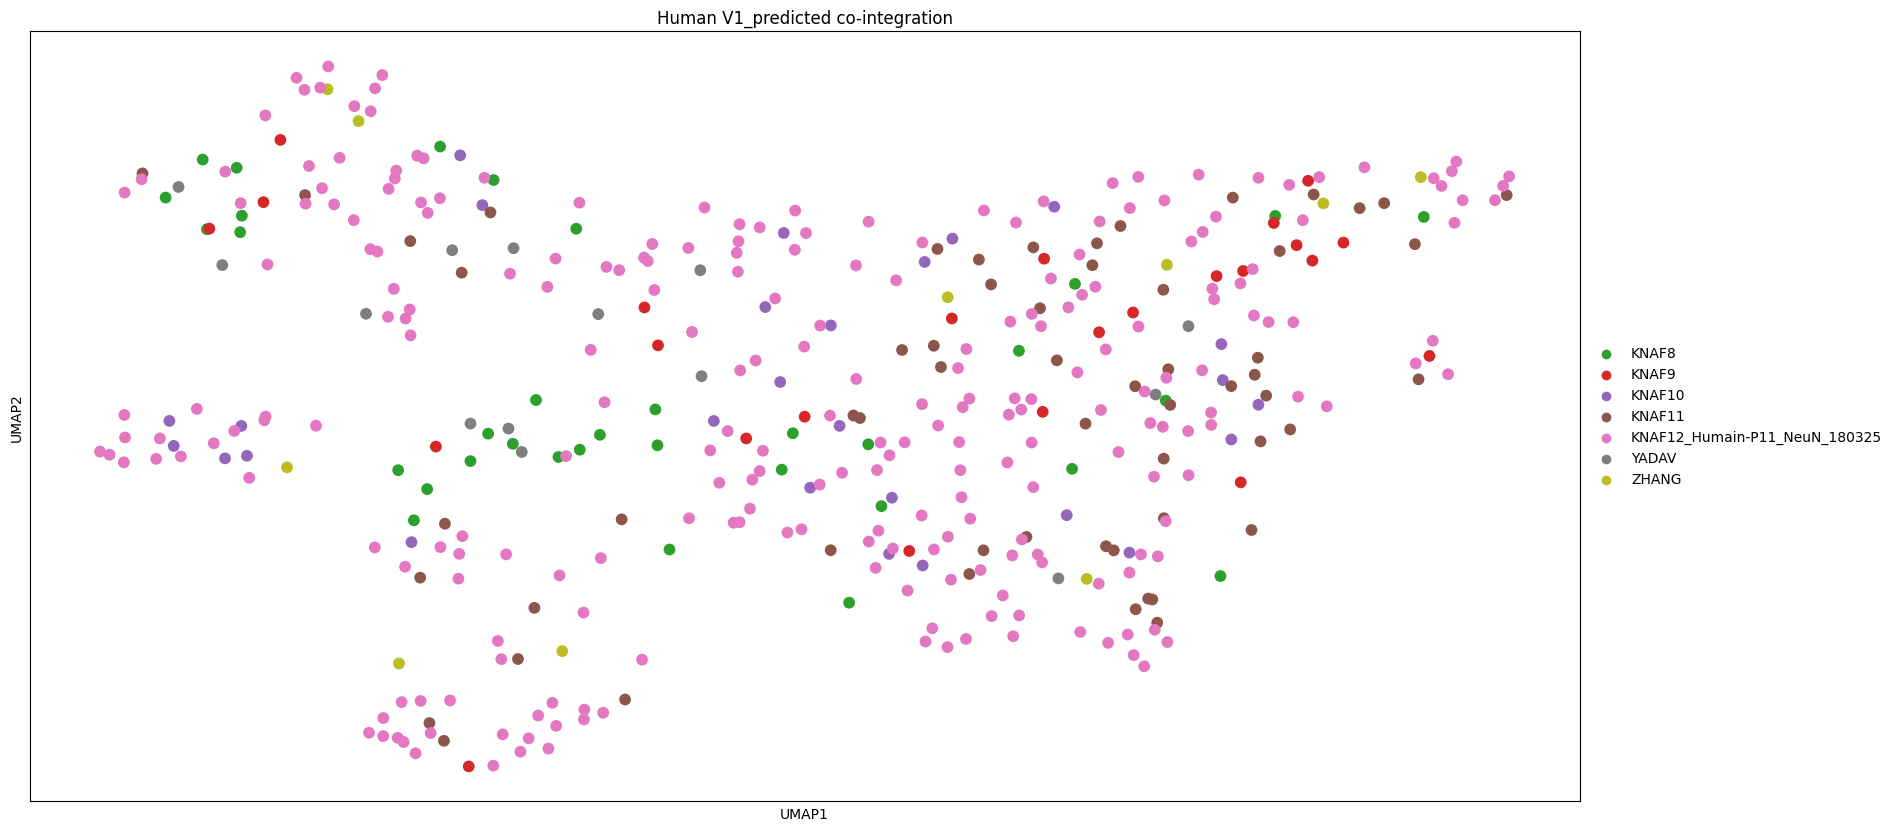

In [8]:
fig, ax = plt.subplots(1,1, figsize = (20,10))
sc.pl.umap(V1_human, color = 'orig.ident', ax=ax, title='Human V1_predicted co-integration')

In [9]:
Z = hierarchy.linkage(V1_human.X, 'ward')

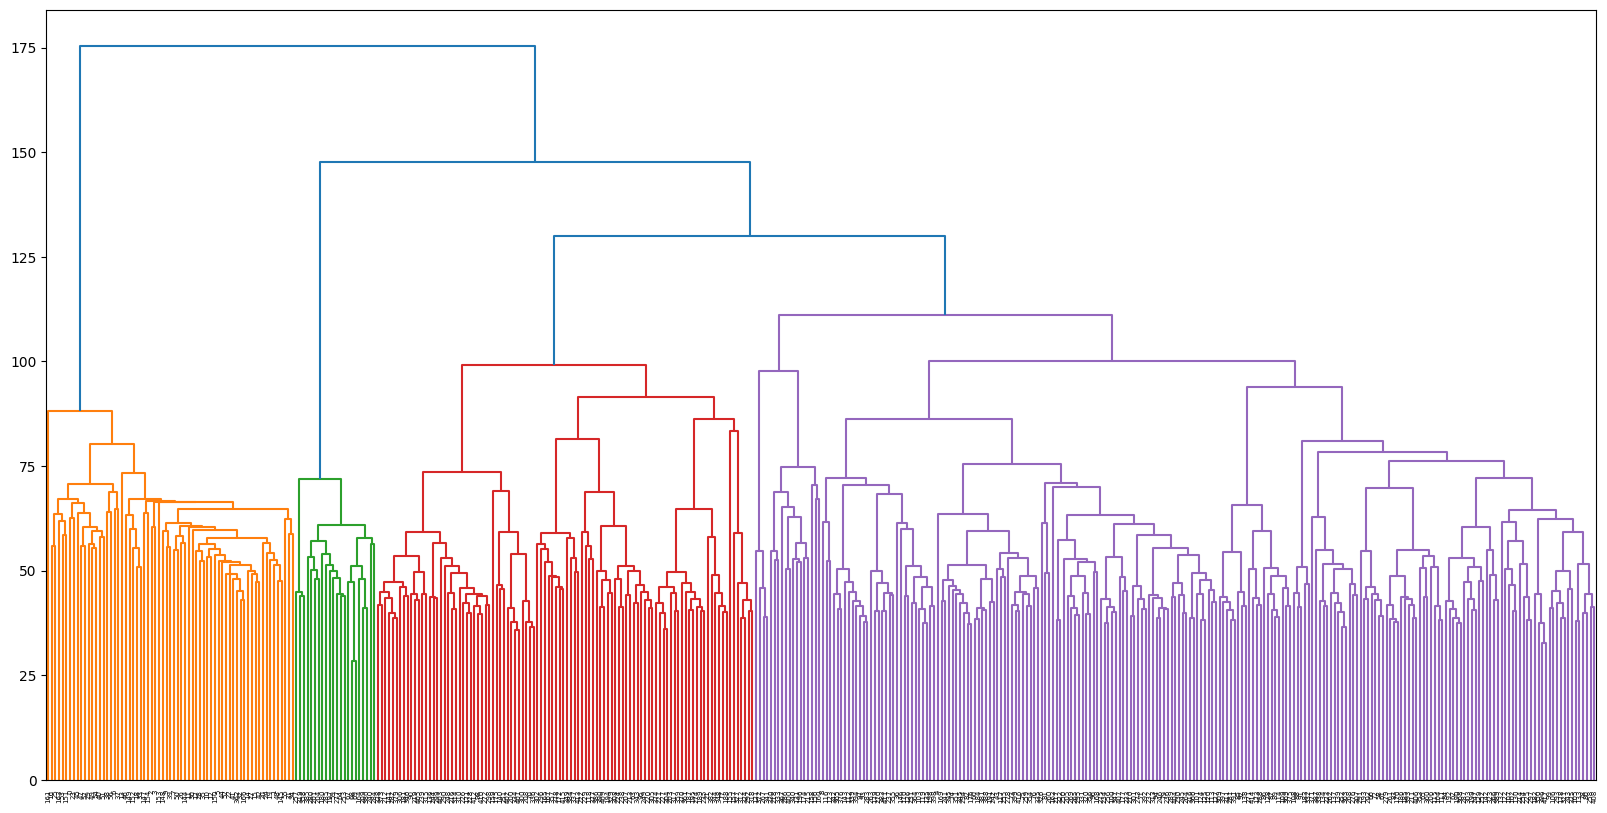

In [10]:
fig, ax = plt.subplots(1,1, figsize = (20,10))
d = hierarchy.dendrogram(Z)

In [11]:
order = {}
for i in range(len(d['leaves'])):
    order[d['leaves'][i]] = d['leaves_color_list'][i]

In [12]:
res = {key: val for key, val in sorted(order.items(), key = lambda ele: ele[0])}
order = res

In [13]:
np.unique(d['leaves_color_list'])

array(['C1', 'C2', 'C3', 'C4'], dtype='<U2')

In [14]:
len(d['leaves_color_list'])

418

In [15]:
V1_human.obs['divise_clusters'] = order.values()

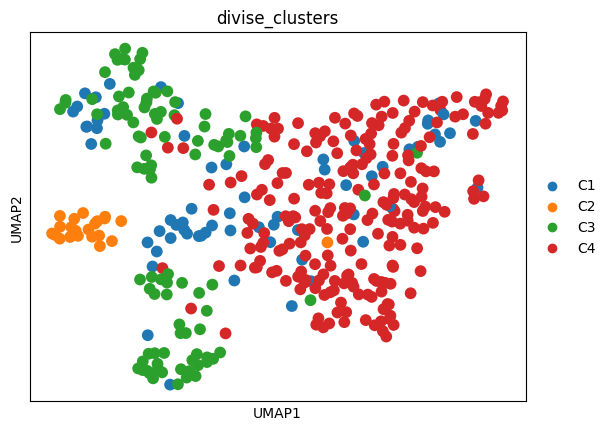

In [16]:
sc.pl.umap(V1_human, color = 'divise_clusters')

In [17]:
V1_human = V1_human[V1_human.obs['divise_clusters'] != 'C0']

In [18]:
human_counts = sc.read_h5ad("data/origin_data/human_neurons_counts.h5ad")
human_counts.obs['annotation'] = V1_human.obs['predicted_annotation']

In [19]:
human_counts = human_counts[human_counts.obs['annotation'].notna()]
human_counts

View of AnnData object with n_obs × n_vars = 168 × 36601
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'doublet_finder', 'percent_mito', 'keep', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.01', 'seurat_clusters', 'celltype', 'SCT_snn_res.0.05', 'annotation'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [20]:
human_counts.obs['divise_clusters'] = V1_human.obs['divise_clusters']

C:\Users\Emile\AppData\Local\Temp\ipykernel_5668\2881673657.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  human_counts.obs['divise_clusters'] = V1_human.obs['divise_clusters']


In [21]:
sc.pp.log1p(human_counts)

c:\Users\Emile\AppData\Local\Programs\Python\Python313\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:357: RuntimeWarning: invalid value encountered in divide
  scores[group_index, :] = (
c:\Users\Emile\AppData\Local\Programs\Python\Python313\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:357: RuntimeWarning: invalid value encountered in divide
  scores[group_index, :] = (
c:\Users\Emile\AppData\Local\Programs\Python\Python313\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:357: RuntimeWarning: invalid value encountered in divide
  scores[group_index, :] = (
c:\Users\Emile\AppData\Local\Programs\Python\Python313\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:357: RuntimeWarning: invalid value encountered in divide
  scores[group_index, :] = (


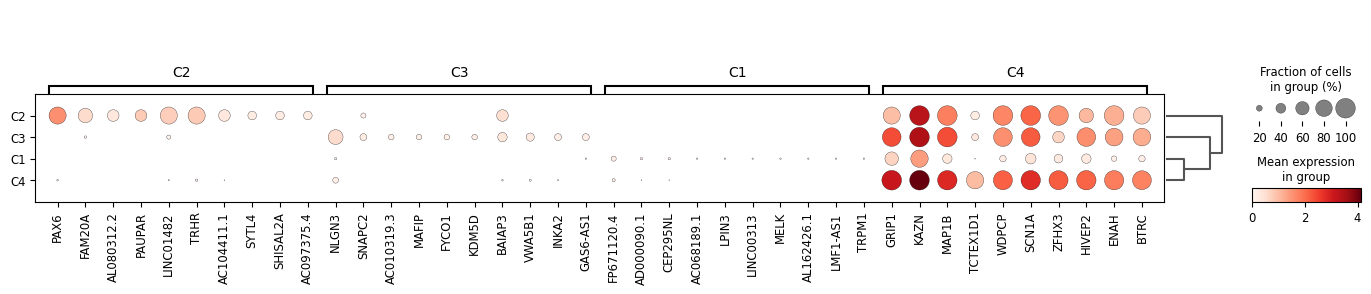

In [22]:
sc.tl.rank_genes_groups(human_counts, groupby='divise_clusters', method = 'wilcoxon', tie_correct=True)
sc.tl.filter_rank_genes_groups(human_counts, min_fold_change=3)
sc.pl.rank_genes_groups_dotplot(human_counts)

In [23]:
from sklearn.cluster import AgglomerativeClustering
X = V1_human.X


clustering = AgglomerativeClustering(n_clusters=5, compute_distances=True, compute_full_tree=True).fit(X)

print(clustering.labels_)

[3 3 3 3 0 3 3 3 0 3 3 3 3 3 3 3 3 3 3 3 3 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0
 3 3 3 3 3 3 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 2 0 0 0 1 2 0 0 2 2 2 1 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 4 0 0 0 0 0 0 0 0 0 4 0 0 0 0 1 0 0 0 1 1 0 0 3 3 0 3
 3 3 3 3 3 3 3 1 4 1 4 1 4 3 0 3 2 1 3 1 0 0 0 1 1 0 4 1 0 0 0 0 2 1 0 0 0
 0 0 1 1 1 0 0 0 0 1 1 4 2 0 0 1 2 0 1 2 0 0 1 1 2 0 0 1 1 0 4 1 0 4 1 1 1
 1 0 1 0 1 1 1 1 0 0 0 0 0 1 0 0 1 1 2 0 0 0 1 0 0 0 1 1 0 1 0 2 0 0 0 2 0
 0 0 0 0 0 0 0 0 4 0 0 0 0 1 0 1 0 0 2 0 0 2 0 1 0 2 2 4 0 0 0 1 0 1 0 0 0
 1 0 1 1 1 0 1 0 1 1 1 0 1 0 1 0 1 0 1 1 0 1 1 2 0 0 0 0 1 0 0 1 1 1 4 0 0
 4 1 0 1 1 0 0 4 4 0 1 1 0 1 0 1 1 0 0 0 0 0 0 0 1 2 1 0 1 3 0 0 0 0 4 0 0
 1 0 4 1 1 0 0 1 1 1 2 0 1 0 1 2 1 0 0 0 1 0 0 0 0 0 0 0 0 0 4 1 1 1 0 1 0
 0 0 1 1 0 1 1 0 1 0 0]


C:\Users\Emile\AppData\Local\Temp\ipykernel_5668\731203339.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  V1_human.obs['clustering'] = clustering.labels_


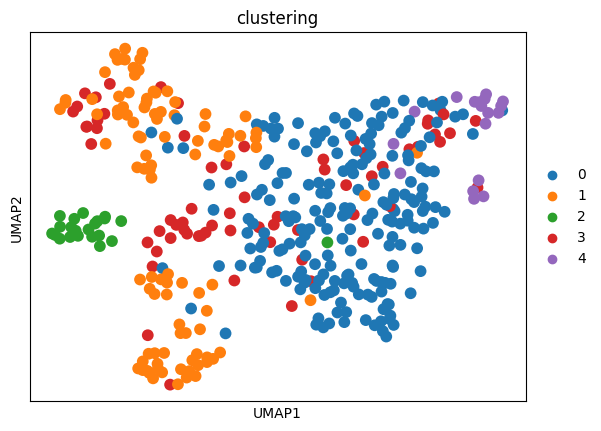

In [24]:
# Plot this clustering

V1_human.obs['clustering'] = clustering.labels_
V1_human.obs['clustering'] = V1_human.obs['clustering'].astype('str')
V1_human.obs['clustering'] = V1_human.obs['clustering'].astype('category')
sc.pl.umap(V1_human, color='clustering')

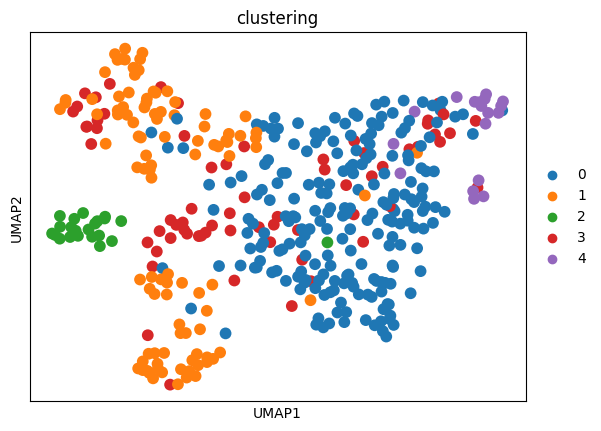

In [25]:
sc.pl.umap(V1_human, color='clustering')

In [26]:
human_counts.obs['agglo_clusters'] = V1_human.obs['clustering']

In [27]:
human_counts = human_counts[human_counts.obs['agglo_clusters'] != '3']

In [28]:
sc.tl.dendrogram(human_counts, groupby='agglo_clusters')

c:\Users\Emile\AppData\Local\Programs\Python\Python313\Lib\site-packages\scanpy\tools\_dendrogram.py:195: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = dat


c:\Users\Emile\AppData\Local\Programs\Python\Python313\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:357: RuntimeWarning: invalid value encountered in divide
  scores[group_index, :] = (
c:\Users\Emile\AppData\Local\Programs\Python\Python313\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:357: RuntimeWarning: invalid value encountered in divide
  scores[group_index, :] = (
c:\Users\Emile\AppData\Local\Programs\Python\Python313\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:357: RuntimeWarning: invalid value encountered in divide
  scores[group_index, :] = (
c:\Users\Emile\AppData\Local\Programs\Python\Python313\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:357: RuntimeWarning: invalid value encountered in divide
  scores[group_index, :] = (


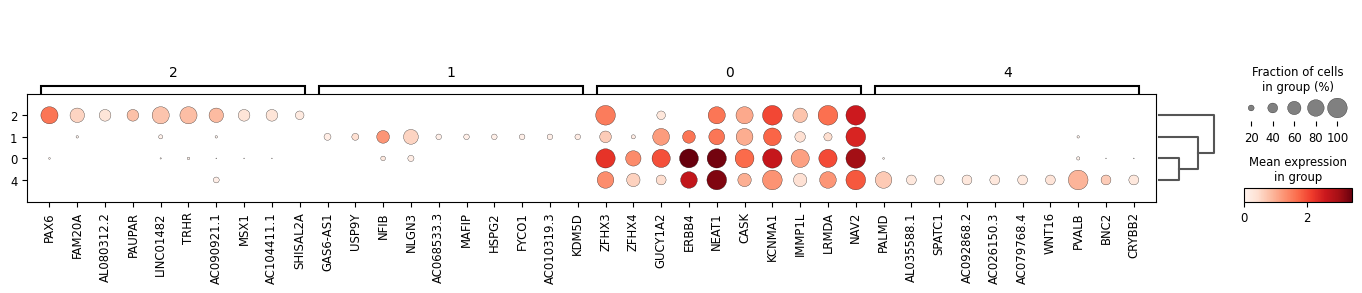

In [29]:
sc.tl.rank_genes_groups(human_counts, groupby='agglo_clusters', method = 'wilcoxon', tie_correct=True)
sc.tl.filter_rank_genes_groups(human_counts, min_fold_change=3)
sc.pl.rank_genes_groups_dotplot(human_counts)

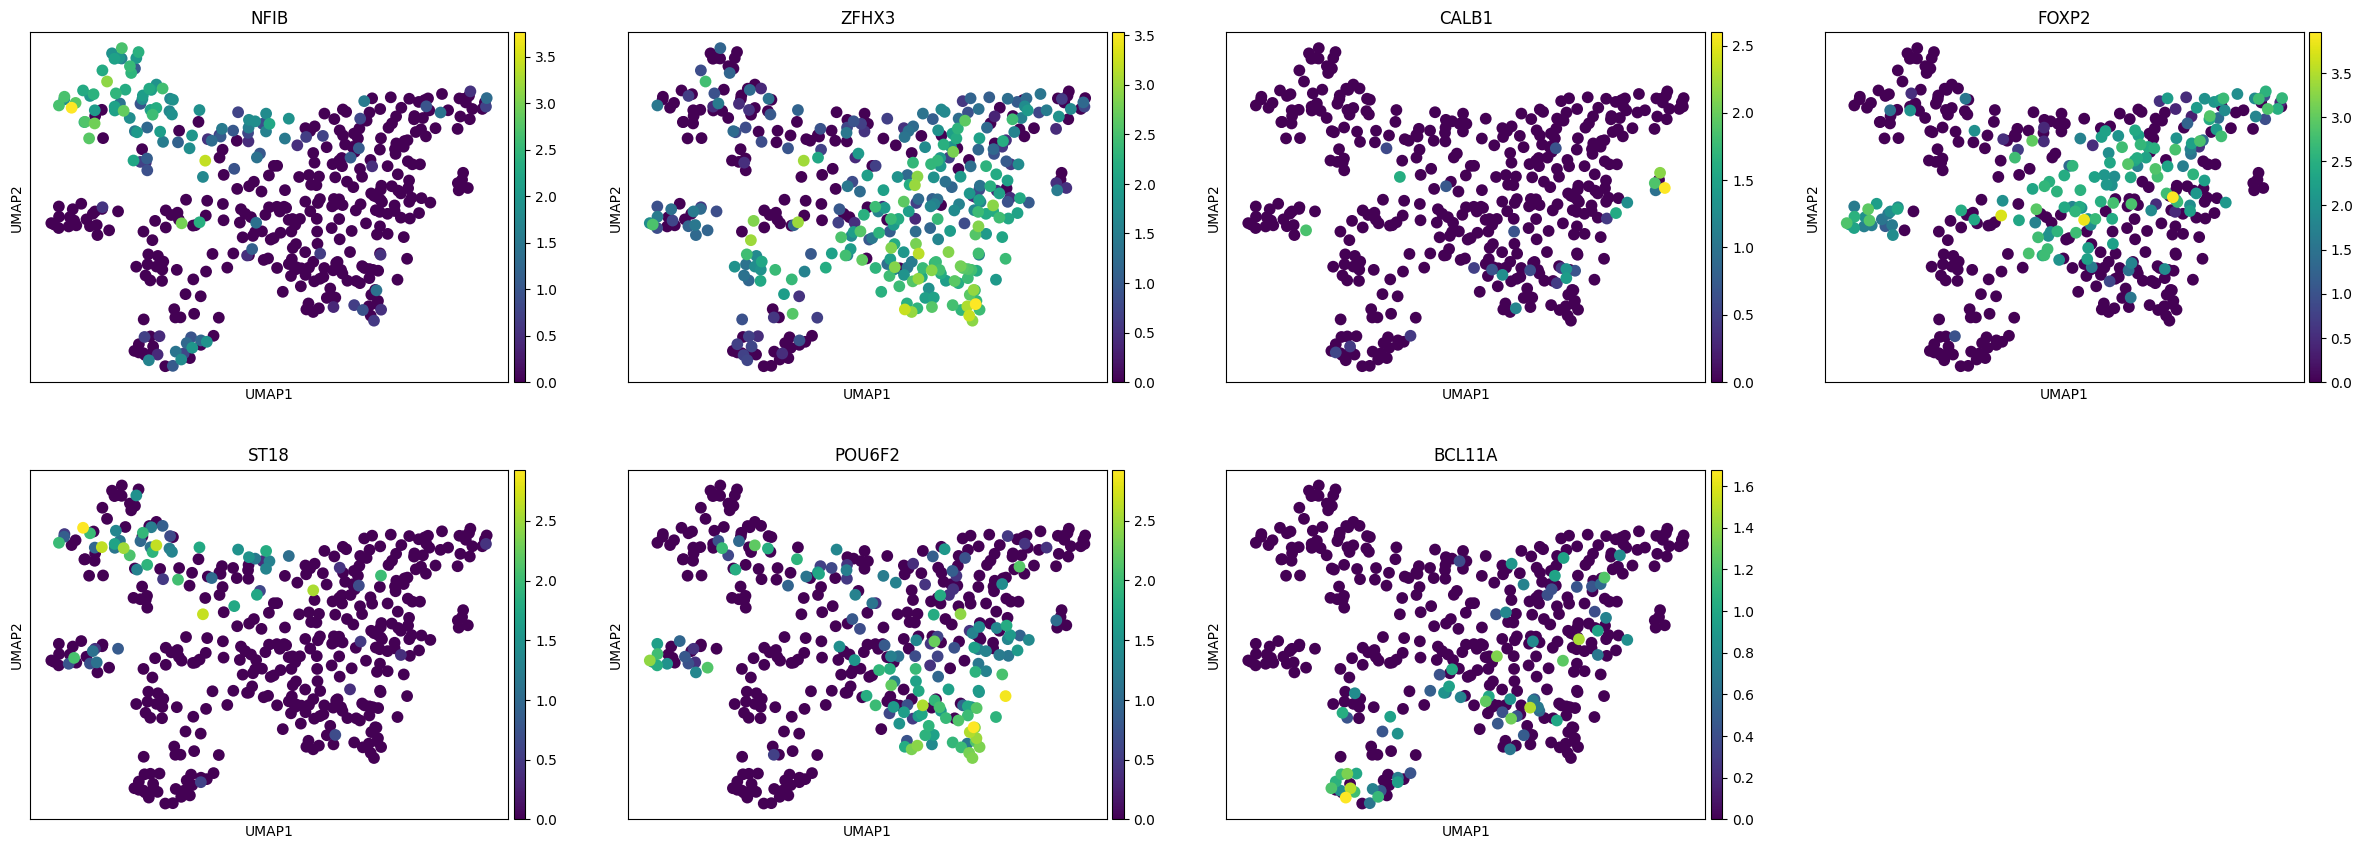

In [30]:
discr_genes =  ['NFIB', 'ZFHX3', 'CALB1', 'FOXP2', 'ST18', 'POU6F2', 'BCL11A']

sc.pl.umap(V1_human, color=discr_genes)

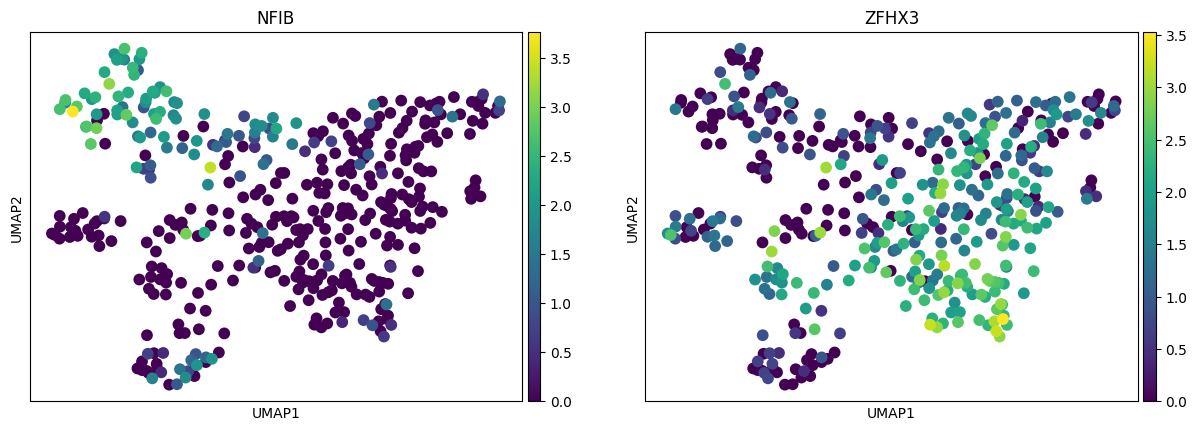

In [31]:
sc.pl.umap(V1_human, color=['NFIB', 'ZFHX3'])

In [38]:
sc.neighbors.neighbors(V1_human, use_rep='X_rpca')
sc.tl.leiden(V1_human, resolution=1.5)

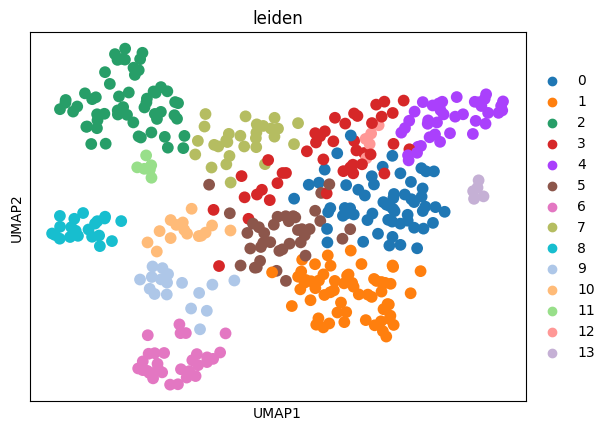

In [39]:
sc.pl.umap(V1_human, color='leiden')

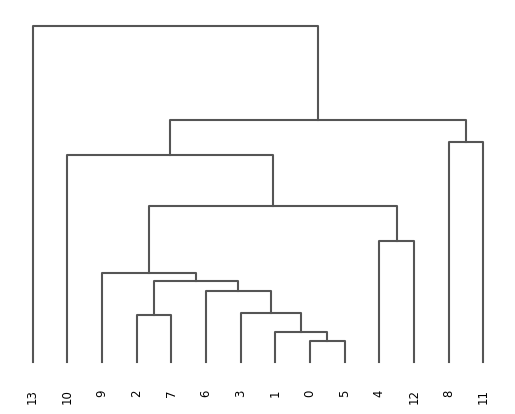

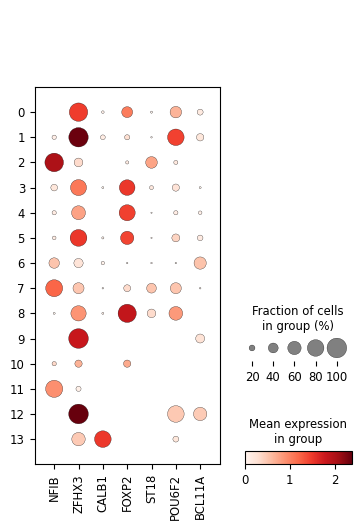

In [40]:
sc.tl.dendrogram(V1_human, groupby= 'leiden', var_names=discr_genes)
sc.pl.dendrogram(V1_human, groupby='leiden')
sc.pl.dotplot(V1_human, discr_genes, groupby='leiden')

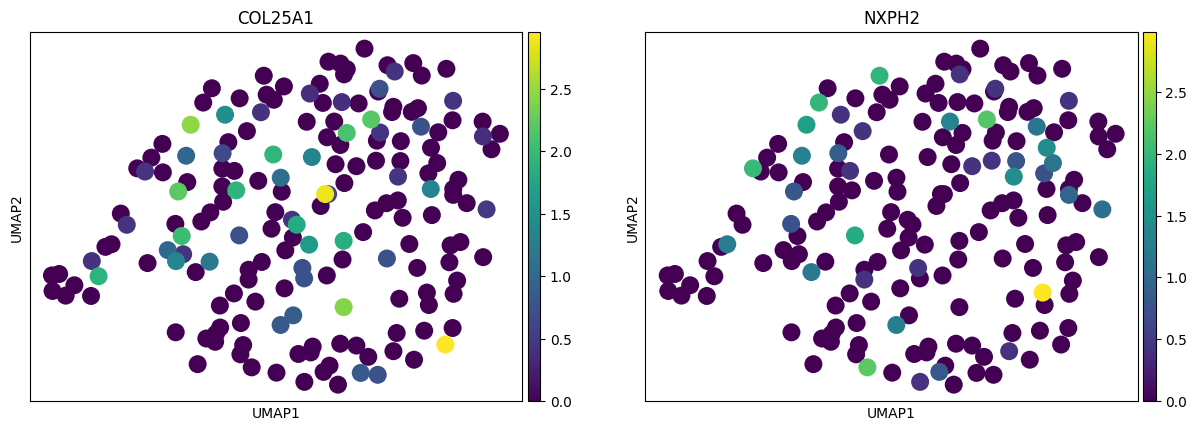

In [39]:
sc.pl.umap(V1_human, color=['COL25A1', 'NXPH2'])

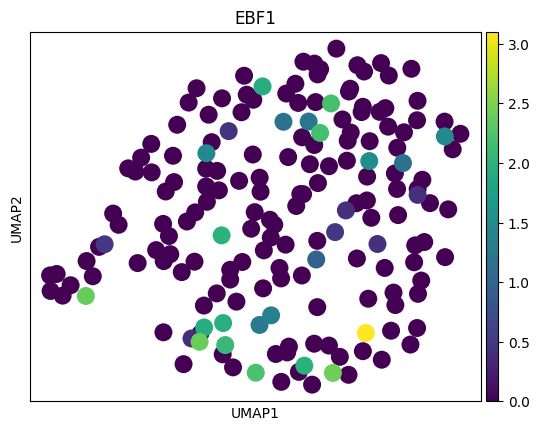

In [40]:
sc.pl.umap(V1_human, color= 'EBF1')